# Buckling Strength ML


## 1. Data loading, inspecting

In [97]:
import os
os.getcwd()

'/Users/sauravkrishna/Documents/Python_stuffs/ML_project/notebooks'

In [98]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [99]:

from pathlib import Path
import pandas as pd
import numpy as np

SHEET_NAME = "Swati (Beam with hole)"

BASE = Path.cwd()
DATA_PATH_CANDIDATES = [
    BASE / "data/raw/data.xlsx",
    BASE / "data/data.xlsx",
    BASE.parent / "data/raw/data.xlsx",
    BASE.parent / "data/data.xlsx",
    Path("/content/data.xlsx"),
]

DATA_PATH = next((p for p in DATA_PATH_CANDIDATES if p.exists()), None)
if DATA_PATH is None:
    raise FileNotFoundError(
        "Could not find data.xlsx. Place it at data/raw/data.xlsx or /content/data.xlsx (Colab)."
    )

for d in [Path("outputs/figures"), Path("outputs/tables"), Path("outputs/models")]:
    d.mkdir(parents=True, exist_ok=True)

print(f"Using DATA_PATH: {DATA_PATH}")


Using DATA_PATH: /Users/sauravkrishna/Documents/Python_stuffs/ML_project/data/data.xlsx


In [100]:
df_raw = pd.read_excel(DATA_PATH, sheet_name=SHEET_NAME)
print("Raw shape:", df_raw.shape)

raw_cols = list(df_raw.columns)
whitespace_cols = [c for c in raw_cols if c != c.strip()]

df = df_raw.copy()
df.columns = [c.strip() for c in raw_cols]

if "SL. No" not in df.columns:
    print("WARNING: 'SL. No' column not found; Units row not dropped.")
    units_rows = 0
else:
    units_mask = df["SL. No"].astype(str).str.strip().eq("Units")
    units_rows = int(units_mask.sum())
    df = df.loc[~units_mask].copy()

print("Units rows removed:", units_rows)
print("Post-drop shape:", df.shape)
print("Columns:", df.columns.tolist())
print("Columns with leading/trailing spaces (pre-strip):", whitespace_cols)

print("Dtype summary:")
print(df.dtypes.value_counts())

missing_pct = (df.isna().mean() * 100).sort_values(ascending=False)
print("Top-10 missingness columns (%):")
print(missing_pct.head(10))


Raw shape: (494, 33)
Units rows removed: 1
Post-drop shape: (493, 33)
Columns: ['SL. No', 'JOURNAL TITLE', 'SPECIMEN', 'SHAPE CODE', 'Boundary condition', 'Loading condition', 'Fy', 'Fu', 'E', 'ν', 't', 'L', 'bw', 'bf1', 'bf2', 'bl1', 'bl2', 'q', 'r', 'HOLE SHAPE', 'l hole', 'h hole', 'r hole', 'Number Of Holes in Channel', 'Distance from top to centre of first hole Y', 'Distance from left  to centre of first hole X', 'Centre to centre distance between adjesent holes in X direction  Sx', 'Ultimate  Buckiling Strength (Mtest)', 'Ultimate  Buckiling Strength (MFEM)', 'Failure Mode', 'AISI', 'Eurocode 3', 'AS/NZS']
Columns with leading/trailing spaces (pre-strip): ['E ', ' bw', 'Number Of Holes in Channel ', 'Distance from top to centre of first hole Y   ']
Dtype summary:
object     32
float64     1
Name: count, dtype: int64
Top-10 missingness columns (%):
AS/NZS                                                                 100.000000
Eurocode 3                                          

In [101]:
df.head()

,SL. No,JOURNAL TITLE,SPECIMEN,SHAPE CODE,Boundary condition,Loading condition,Fy,Fu,E,ν,t,L,bw,bf1,bf2,bl1,bl2,q,r,HOLE SHAPE,l hole,h hole,r hole,Number Of Holes in Channel,Distance from top to centre of first hole Y,Distance from left to centre of first hole X,Centre to centre distance between adjesent holes in X direction Sx,Ultimate Buckiling Strength (Mtest),Ultimate Buckiling Strength (MFEM),Failure Mode,AISI,Eurocode 3,AS/NZS
1,1,Moen et al. 2013,NH-1.1,C,Pinned and roller,four point loading,380,437.0,203500,0.3,1.76,4878,203,63,63.4,15.4,13.9,NaN,4.475,no hole,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.6,10.6,Distortional and local,10.6,NaN,NaN
2,2,Moen et al. 2013,NH-1.2,C,Pinned and roller,four point loading,363,417.45,203500,0.3,1.77,4878,203.2,62.8,63.4,15.3,14,NaN,4.875,no hole,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.6,10.6,Distortional and local,ˉ,NaN,NaN
3,3,Moen et al. 2013,NH-2.1,C,Pinned and roller,four point loading,364,418.6,203500,0.3,1.76,4878,203.3,62.7,63.5,15.4,14.2,NaN,4.75,no hole,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.5,10.5,Distortional and local,10.5,NaN,NaN
4,4,Moen et al. 2013,NH-2.2,C,Pinned and roller,four point loading,375,431.25,203500,0.3,1.78,4878,203.1,62.7,63.5,15.2,14,NaN,4.675,no hole,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.5,10.5,Distortional and local,ˉ,NaN,NaN
5,5,Moen et al. 2013,NH-3.1,C,Pinned and roller,four point loading,378,434.7,203500,0.3,1.78,4878,203.1,62.7,63.5,13.1,14.2,NaN,4.9,no hole,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13,10.6,Distortional and local,ˉ,NaN,NaN


In [102]:
df.tail()

,SL. No,JOURNAL TITLE,SPECIMEN,SHAPE CODE,Boundary condition,Loading condition,Fy,Fu,E,ν,t,L,bw,bf1,bf2,bl1,bl2,q,r,HOLE SHAPE,l hole,h hole,r hole,Number Of Holes in Channel,Distance from top to centre of first hole Y,Distance from left to centre of first hole X,Centre to centre distance between adjesent holes in X direction Sx,Ultimate Buckiling Strength (Mtest),Ultimate Buckiling Strength (MFEM),Failure Mode,AISI,Eurocode 3,AS/NZS
489,491,"Tohamy et al., 2021",B-C04,C,Pinned and roller,four point loading,295,412,208000,0.3,2.5,3000,250,43,43,15,15,NaN,2,Circle,NaN,NaN,50,1,125,1500,NaN,11.1,NaN,local-distortional,NaN,NaN,NaN
490,492,"Tohamy et al., 2021",B-C05,C,Pinned and roller,four point loading,295,412,208000,0.3,2.5,3000,250,43,43,15,15,NaN,2,Circle,NaN,NaN,62.5,1,125,1500,NaN,10.87,NaN,local-distortional,NaN,NaN,NaN
491,493,"Tohamy et al., 2021",B-C06,C,Pinned and roller,four point loading,295,412,208000,0.3,2.5,3000,250,43,43,15,15,NaN,2,Circle,NaN,NaN,75,1,125,1500,NaN,10.5,NaN,local-distortional,NaN,NaN,NaN
492,494,"Tohamy et al., 2021",B-C07,C,Pinned and roller,four point loading,295,412,208000,0.3,2.5,3000,250,43,43,15,15,NaN,2,Circle,NaN,NaN,87.5,1,125,1500,NaN,9.93,NaN,local-distortional,NaN,NaN,NaN
493,495,"Tohamy et al., 2021",B-C08,C,Pinned and roller,four point loading,295,412,208000,0.3,2.5,3000,250,43,43,15,15,NaN,2,Circle,NaN,NaN,100,1,125,1500,NaN,9.07,NaN,local-distortional,NaN,NaN,NaN


In [103]:
# Phase 1 — Target construction + QC
MTEST_COL = "Ultimate  Buckiling Strength (Mtest)"
MFEM_COL = "Ultimate  Buckiling Strength (MFEM)"

y_mtest = df[MTEST_COL]
y_mfem = df[MFEM_COL]

y_from_fem = y_mtest.isna() & y_mfem.notna()
y_filled = y_mtest.fillna(y_mfem)
y = pd.to_numeric(y_filled, errors="coerce")

rows_before = len(df)
rows_after = int(y.notna().sum())
rows_dropped = rows_before - rows_after


print("Rows before:", rows_before)
print("Rows after:", rows_after)
print("Rows dropped (non-numeric target):", rows_dropped)


Rows before: 493
Rows after: 492
Rows dropped (non-numeric target): 1


In [104]:
df = df.loc[y.notna()].copy()
df["y"] = y.loc[y.notna()].astype(float)
df["y_from_fem"] = y_from_fem.loc[y.notna()]

fill_count = int(y_from_fem.sum())
non_numeric_count = int(y_filled.notna().sum() - y.notna().sum())

missing_rates = pd.Series({
    "Mtest_missing_pct": y_mtest.isna().mean() * 100,
    "MFEM_missing_pct": y_mfem.isna().mean() * 100,
    "filled_missing_pct": y_filled.isna().mean() * 100,
})

print("Rows before:", rows_before)
print("Rows after:", rows_after)
print("Rows dropped (non-numeric target):", rows_dropped)
print("Filled from MFEM:", fill_count)
print("Non-numeric targets after fill:", non_numeric_count)
print("Missingness rates (%):")
print(missing_rates.round(3))

Rows before: 493
Rows after: 492
Rows dropped (non-numeric target): 1
Filled from MFEM: 346
Non-numeric targets after fill: 1
Missingness rates (%):
Mtest_missing_pct     70.183
MFEM_missing_pct      17.039
filled_missing_pct     0.000
dtype: float64


In [105]:
len(df)

492

In [106]:
# Phase 2 — Feature set definition + pruning
MTEST_COL = "Ultimate  Buckiling Strength (Mtest)"
MFEM_COL = "Ultimate  Buckiling Strength (MFEM)"

META_COLS = ["JOURNAL TITLE", "SPECIMEN"]

DROP_COLS = [
    "SL. No", "SHAPE CODE", "Boundary condition", "Loading condition",
    "Failure Mode", "AISI", "Eurocode 3", "AS/NZS", "q",
    MTEST_COL, MFEM_COL, "y", "y_from_fem"
]

drop_cols_present = [c for c in DROP_COLS if c in df.columns]
meta_cols_present = [c for c in META_COLS if c in df.columns]
missing_expected = [c for c in DROP_COLS + META_COLS if c not in df.columns]

drop_cols_present, meta_cols_present, missing_expected


(['SL. No',
  'SHAPE CODE',
  'Boundary condition',
  'Loading condition',
  'Failure Mode',
  'AISI',
  'Eurocode 3',
  'AS/NZS',
  'q',
  'Ultimate  Buckiling Strength (Mtest)',
  'Ultimate  Buckiling Strength (MFEM)',
  'y',
  'y_from_fem'],
 ['JOURNAL TITLE', 'SPECIMEN'],
 [])

In [107]:
X_full = df.drop(columns=drop_cols_present + meta_cols_present).copy()
meta = df[meta_cols_present].copy()

nunique = X_full.nunique(dropna=True)
constant_cols = nunique[nunique <= 1].index.tolist()
X_full = X_full.drop(columns=constant_cols)
feature_cols = X_full.columns.tolist()

def is_numeric_col(s, threshold=0.9):
    if pd.api.types.is_numeric_dtype(s):
        return True
    s_non_null = s.dropna()
    if s_non_null.empty:
        return False
    converted = pd.to_numeric(s_non_null, errors="coerce")
    return converted.notna().mean() >= threshold

numeric_cols = [c for c in feature_cols if is_numeric_col(X_full[c])]
categorical_cols = [c for c in feature_cols if c not in numeric_cols]

print("Dropped columns (non-features):", drop_cols_present)
print("Meta columns (kept only for diagnostics):", meta_cols_present)
if missing_expected:
    print("Missing expected columns (check names):", missing_expected)
print("Constant columns dropped:", constant_cols)
print(f"Final feature columns (n={len(feature_cols)}):")
print(feature_cols)
print(f"Numeric features: {len(numeric_cols)}")
print(f"Categorical features: {len(categorical_cols)}")

Dropped columns (non-features): ['SL. No', 'SHAPE CODE', 'Boundary condition', 'Loading condition', 'Failure Mode', 'AISI', 'Eurocode 3', 'AS/NZS', 'q', 'Ultimate  Buckiling Strength (Mtest)', 'Ultimate  Buckiling Strength (MFEM)', 'y', 'y_from_fem']
Meta columns (kept only for diagnostics): ['JOURNAL TITLE', 'SPECIMEN']
Constant columns dropped: ['ν']
Final feature columns (n=19):
['Fy', 'Fu', 'E', 't', 'L', 'bw', 'bf1', 'bf2', 'bl1', 'bl2', 'r', 'HOLE SHAPE', 'l hole', 'h hole', 'r hole', 'Number Of Holes in Channel', 'Distance from top to centre of first hole Y', 'Distance from left  to centre of first hole X', 'Centre to centre distance between adjesent holes in X direction  Sx']
Numeric features: 18
Categorical features: 1


In [108]:
nunique

Fy                                                                     47
Fu                                                                     47
E                                                                       7
ν                                                                       1
t                                                                      77
L                                                                      17
bw                                                                     79
bf1                                                                    84
bf2                                                                    82
bl1                                                                    69
bl2                                                                    79
r                                                                      57
HOLE SHAPE                                                              9
l hole                                

In [109]:
# Phase 2.5 — Diagnostics for E and hole count (no data changes)

E_col = "E"
holes_col = "Number Of Holes in Channel"
sx_col = "Centre to centre distance between adjesent holes in X direction  Sx"
shape_col = "HOLE SHAPE"

E_num = pd.to_numeric(df[E_col], errors="coerce")
holes_num = pd.to_numeric(df[holes_col], errors="coerce")

print("E non-numeric count:", int(df[E_col].notna().sum() - E_num.notna().sum()))
print("E unique (numeric):", int(E_num.nunique(dropna=True)))
print("E top values:")
print(E_num.value_counts(dropna=True).head(10))

e_per_journal = df.assign(E_num=E_num).groupby("JOURNAL TITLE")["E_num"].nunique().sort_values(ascending=False)
print("Journals with multiple E values (top 10):")
print(e_per_journal.head(10))
print("Count of journals with >1 E:", int((e_per_journal > 1).sum()))

print("Number Of Holes distribution:")
print(holes_num.value_counts(dropna=False).sort_index())

sx_present_for_single = df.loc[holes_num <= 1, sx_col].notna().sum()
print("Sx present when holes <= 1:", int(sx_present_for_single))

print("HOLE SHAPE distribution:")
print(df[shape_col].value_counts(dropna=False).head(10))


E non-numeric count: 0
E unique (numeric): 7
E top values:
E
200000    282
206000     88
202800     84
203500     18
203000      9
208000      8
196000      3
Name: count, dtype: int64
Journals with multiple E values (top 10):
JOURNAL TITLE
 Chen et al.,2020            1
Chandramohan et al., 2025    1
Moen et al. 2013             1
Oruç 1 2025                  1
Sadid et al., 2025           1
Sivakumaran et al., 2006     1
Soroori Rad 2010             1
Soroori Rad 2011             1
Tohamy et al., 2021          1
Zhao et al., 2019            1
Name: E_num, dtype: int64
Count of journals with >1 E: 0
Number Of Holes distribution:
Number Of Holes in Channel
1.0    206
2.0     11
3.0    227
4.0      4
5.0      7
8.0      3
NaN     34
Name: count, dtype: int64
Sx present when holes <= 1: 5
HOLE SHAPE distribution:
HOLE SHAPE
Elongated    204
Rectangle    115
Square       105
no hole       30
circle        17
Circle        11
No hole        4
square         3
rectangle      3
Name: count, 

In [110]:
E_col = "E"
jt_col = "JOURNAL TITLE"

# convert and inspect non-numeric entries
E_num = pd.to_numeric(df[E_col], errors="coerce")
non_numeric_examples = df.loc[df[E_col].notna() & E_num.isna(), E_col].unique()[:20]
print("Examples of non-numeric E values (up to 20):", non_numeric_examples)

# numeric summary
print("Count numeric E:", int(E_num.notna().sum()))
print("Unique numeric E values:", int(E_num.nunique(dropna=True)))
print("Numeric E top values:")
print(E_num.value_counts(dropna=True).head(10))

# per-journal uniqueness of E
e_per_journal = df.assign(E_num=E_num).groupby(jt_col)["E_num"].nunique().sort_values(ascending=False)
print("Journals with multiple numeric E values (top 10):")
print(e_per_journal.head(10))
print("Number of journals with >1 E value:", int((e_per_journal > 1).sum()))

# per-E how many journals share the same E
journals_per_e = df.assign(E_num=E_num).dropna(subset=["E_num"]).groupby("E_num")[jt_col].nunique().sort_values(ascending=False)
print("E values shared by many journals (top 10):")
print(journals_per_e.head(10))
print("Number of E values mapping to >1 journal:", int((journals_per_e > 1).sum()))

# check bijection counts
pairs = df[[E_col, jt_col]].drop_duplicates()
pairs_num = pairs.assign(E_num=pd.to_numeric(pairs[E_col], errors="coerce")).dropna(subset=["E_num"])
e_to_journal_multi = pairs_num.groupby("E_num")[jt_col].nunique()
journal_to_e_multi = pairs_num.groupby(jt_col)["E_num"].nunique()
print("E values that map to >1 journal:", int((e_to_journal_multi > 1).sum()))
print("Journals that map to >1 E value:", int((journal_to_e_multi > 1).sum()))

Examples of non-numeric E values (up to 20): []
Count numeric E: 492
Unique numeric E values: 7
Numeric E top values:
E
200000    282
206000     88
202800     84
203500     18
203000      9
208000      8
196000      3
Name: count, dtype: int64
Journals with multiple numeric E values (top 10):
JOURNAL TITLE
 Chen et al.,2020            1
Chandramohan et al., 2025    1
Moen et al. 2013             1
Oruç 1 2025                  1
Sadid et al., 2025           1
Sivakumaran et al., 2006     1
Soroori Rad 2010             1
Soroori Rad 2011             1
Tohamy et al., 2021          1
Zhao et al., 2019            1
Name: E_num, dtype: int64
Number of journals with >1 E value: 0
E values shared by many journals (top 10):
E_num
200000    4
196000    1
202800    1
203000    1
203500    1
206000    1
208000    1
Name: JOURNAL TITLE, dtype: int64
Number of E values mapping to >1 journal: 1
E values that map to >1 journal: 1
Journals that map to >1 E value: 0


In [111]:
# Phase 3A — Normalize HOLE SHAPE (log before/after)
shape_col = "HOLE SHAPE"

shape_before = df[shape_col].value_counts(dropna=False)

shape_norm = (
    df[shape_col]
      .astype(str)
      .str.strip()
      .str.lower()
      .str.replace(r"\s+", " ", regex=True)
)
shape_norm = shape_norm.replace("nan", np.nan)
shape_norm = shape_norm.replace({
    "no hole": "no_hole",
    "no_hole": "no_hole",
    "circle": "circle",
    "square": "square",
    "rectangle": "rectangle",
    "elongated": "elongated",
})

canonical_shapes = {"circle", "square", "rectangle", "elongated", "no_hole"}
unknown_shapes = sorted(set(shape_norm.dropna().unique()) - canonical_shapes)

df[shape_col] = shape_norm
shape_after = df[shape_col].value_counts(dropna=False)

print("HOLE SHAPE before normalization:")
print(shape_before)
print("\nHOLE SHAPE after normalization:")
print(shape_after)
print("\nUnknown shapes after normalization:", unknown_shapes)


HOLE SHAPE before normalization:
HOLE SHAPE
Elongated    204
Rectangle    115
Square       105
no hole       30
circle        17
Circle        11
No hole        4
square         3
rectangle      3
Name: count, dtype: int64

HOLE SHAPE after normalization:
HOLE SHAPE
elongated    204
rectangle    118
square       108
no_hole       34
circle        28
Name: count, dtype: int64

Unknown shapes after normalization: []


In [112]:
# Phase 3B — Conditional missingness tables
holes_col = "Number Of Holes in Channel"
sx_col = "Centre to centre distance between adjesent holes in X direction  Sx"

hole_cols = [
    "l hole", "h hole", "r hole",
    holes_col,
    "Distance from top to centre of first hole Y",
    "Distance from left  to centre of first hole X",
    sx_col,
]

def missingness_by_group(frame, group_col, cols):
    missing_pct = frame.groupby(group_col, dropna=False)[cols].apply(lambda g: g.isna().mean() * 100)
    counts = frame.groupby(group_col, dropna=False).size().rename("n")
    return missing_pct.join(counts)



In [113]:
shape_col

'HOLE SHAPE'

In [114]:
# By HOLE SHAPE
shape_missing_tbl = missingness_by_group(df, shape_col, hole_cols)
print("Missingness by HOLE SHAPE (%):")
shape_missing_tbl.round(1)



Missingness by HOLE SHAPE (%):


,l hole,h hole,r hole,Number Of Holes in Channel,Distance from top to centre of first hole Y,Distance from left to centre of first hole X,Centre to centre distance between adjesent holes in X direction Sx,n
HOLE SHAPE,,,,,,,,
circle,100.0,100.0,0.0,0.0,0.0,0.0,53.6,28
elongated,0.0,0.0,0.0,0.0,0.0,0.0,64.7,204
no_hole,100.0,100.0,100.0,100.0,52.9,100.0,100.0,34
rectangle,0.0,0.0,100.0,0.0,0.0,0.0,18.6,118
square,0.0,0.0,100.0,0.0,0.0,0.0,33.3,108


In [115]:
# By number of holes
holes_num = pd.to_numeric(df[holes_col], errors="coerce")
holes_missing_tbl = missingness_by_group(df.assign(_holes_num=holes_num), "_holes_num", hole_cols)
print("\nMissingness by Number Of Holes (%):")
holes_missing_tbl.round(1)




Missingness by Number Of Holes (%):


,l hole,h hole,r hole,Number Of Holes in Channel,Distance from top to centre of first hole Y,Distance from left to centre of first hole X,Centre to centre distance between adjesent holes in X direction Sx,n
_holes_num,,,,,,,,
1.0,7.3,7.3,28.6,0.0,0.0,0.0,97.6,206
2.0,9.1,9.1,90.9,0.0,0.0,0.0,0.0,11
3.0,2.2,2.2,66.1,0.0,0.0,0.0,1.8,227
4.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,4
5.0,57.1,57.1,42.9,0.0,0.0,0.0,0.0,7
8.0,100.0,100.0,0.0,0.0,0.0,0.0,0.0,3
NaN,100.0,100.0,100.0,100.0,52.9,100.0,100.0,34


In [116]:
# Sx missingness by number of holes
sx_missing_by_holes = (
    df.assign(_holes_num=holes_num)
      .groupby("_holes_num", dropna=False)[sx_col]
      .apply(lambda s: s.isna().mean() * 100)
      .rename("Sx_missing_pct")
)
print("\nSx missingness by Number Of Holes (%):")
sx_missing_by_holes.round(1)


Sx missingness by Number Of Holes (%):


_holes_num
1.0     97.6
2.0      0.0
3.0      1.8
4.0      0.0
5.0      0.0
8.0      0.0
NaN    100.0
Name: Sx_missing_pct, dtype: float64

In [117]:
# Phase 3C — Inconsistency flags (no fixes yet)
holes_col = "Number Of Holes in Channel"
sx_col = "Centre to centre distance between adjesent holes in X direction  Sx"

hole_meta_cols = [
    "l hole", "h hole", "r hole",
    holes_col,
    "Distance from top to centre of first hole Y",
    "Distance from left  to centre of first hole X",
    sx_col,
]

holes_num = pd.to_numeric(df[holes_col], errors="coerce")
no_hole_mask = df[shape_col].eq("no_hole")

no_hole_any_present = df.loc[no_hole_mask, hole_meta_cols].notna().any(axis=1)
df["inconsistent_no_hole_metadata"] = False
df.loc[no_hole_mask, "inconsistent_no_hole_metadata"] = no_hole_any_present

df["inconsistent_sx_for_single_hole"] = (holes_num <= 1) & df[sx_col].notna()

print("inconsistent_no_hole_metadata count:", int(df["inconsistent_no_hole_metadata"].sum()))
print("inconsistent_sx_for_single_hole count:", int(df["inconsistent_sx_for_single_hole"].sum()))

print("\nno_hole non-null counts by column:")
print(df.loc[no_hole_mask, hole_meta_cols].notna().sum().sort_values(ascending=False))

print("\nSample rows with inconsistent_no_hole_metadata:")
display(df.loc[df["inconsistent_no_hole_metadata"], [shape_col] + hole_meta_cols])

print("\nSample rows with inconsistent_sx_for_single_hole:")
display(df.loc[df["inconsistent_sx_for_single_hole"], [shape_col, holes_col, sx_col]])



inconsistent_no_hole_metadata count: 16
inconsistent_sx_for_single_hole count: 5

no_hole non-null counts by column:
Distance from top to centre of first hole Y                            16
l hole                                                                  0
h hole                                                                  0
r hole                                                                  0
Number Of Holes in Channel                                              0
Distance from left  to centre of first hole X                           0
Centre to centre distance between adjesent holes in X direction  Sx     0
dtype: int64

Sample rows with inconsistent_no_hole_metadata:


,HOLE SHAPE,l hole,h hole,r hole,Number Of Holes in Channel,Distance from top to centre of first hole Y,Distance from left to centre of first hole X,Centre to centre distance between adjesent holes in X direction Sx
33,no_hole,NaN,NaN,NaN,NaN,ˍ,NaN,NaN
83,no_hole,NaN,NaN,NaN,NaN,90,NaN,NaN
84,no_hole,NaN,NaN,NaN,NaN,90,NaN,NaN
85,no_hole,NaN,NaN,NaN,NaN,90,NaN,NaN
86,no_hole,NaN,NaN,NaN,NaN,90,NaN,NaN
87,no_hole,NaN,NaN,NaN,NaN,90,NaN,NaN
88,no_hole,NaN,NaN,NaN,NaN,90,NaN,NaN
89,no_hole,NaN,NaN,NaN,NaN,90,NaN,NaN
128,no_hole,NaN,NaN,NaN,NaN,99.7,NaN,NaN
129,no_hole,NaN,NaN,NaN,NaN,99.8,NaN,NaN



Sample rows with inconsistent_sx_for_single_hole:


,HOLE SHAPE,Number Of Holes in Channel,Centre to centre distance between adjesent holes in X direction Sx
38,square,1,650
308,elongated,1,408
359,elongated,1,408
410,elongated,1,408
461,elongated,1,408


In [118]:
# Phase 3D — Display inconsistencies clearly (diagnostic only)
id_cols = [c for c in ["SL. No", "JOURNAL TITLE", "SPECIMEN"] if c in df.columns]
holes_col = "Number Of Holes in Channel"
sx_col = "Centre to centre distance between adjesent holes in X direction  Sx"
shape_col = "HOLE SHAPE"

hole_meta_cols = [
    "l hole", "h hole", "r hole",
    holes_col,
    "Distance from top to centre of first hole Y",
    "Distance from left  to centre of first hole X",
    sx_col,
]

inc_no_hole = df.loc[df["inconsistent_no_hole_metadata"], id_cols + [shape_col] + hole_meta_cols]
inc_sx = df.loc[df["inconsistent_sx_for_single_hole"], id_cols + [shape_col, holes_col, sx_col]]

print("inconsistent_no_hole_metadata (rows):", len(inc_no_hole))
display(inc_no_hole)

print("inconsistent_sx_for_single_hole (rows):", len(inc_sx))
display(inc_sx)


inconsistent_no_hole_metadata (rows): 16


,SL. No,JOURNAL TITLE,SPECIMEN,HOLE SHAPE,l hole,h hole,r hole,Number Of Holes in Channel,Distance from top to centre of first hole Y,Distance from left to centre of first hole X,Centre to centre distance between adjesent holes in X direction Sx
33,33,Oruç 1 2025,NH− 1,no_hole,NaN,NaN,NaN,NaN,ˍ,NaN,NaN
83,83,Oruç 1 2025,NH_0.5,no_hole,NaN,NaN,NaN,NaN,90,NaN,NaN
84,84,Oruç 1 2025,NH_1,no_hole,NaN,NaN,NaN,NaN,90,NaN,NaN
85,85,Oruç 1 2025,NH_1.5,no_hole,NaN,NaN,NaN,NaN,90,NaN,NaN
86,86,Oruç 1 2025,NH_2.5,no_hole,NaN,NaN,NaN,NaN,90,NaN,NaN
87,87,Oruç 1 2025,NH_3,no_hole,NaN,NaN,NaN,NaN,90,NaN,NaN
88,88,Oruç 1 2025,NH_3.5,no_hole,NaN,NaN,NaN,NaN,90,NaN,NaN
89,89,Oruç 1 2025,NH_4,no_hole,NaN,NaN,NaN,NaN,90,NaN,NaN
128,128,"Zhao et al., 2019",H200r0d40t2.0-1,no_hole,NaN,NaN,NaN,NaN,99.7,NaN,NaN
129,129,"Zhao et al., 2019",H200r0d40t2.0-2,no_hole,NaN,NaN,NaN,NaN,99.8,NaN,NaN


inconsistent_sx_for_single_hole (rows): 5


,SL. No,JOURNAL TITLE,SPECIMEN,HOLE SHAPE,Number Of Holes in Channel,Centre to centre distance between adjesent holes in X direction Sx
38,38,Oruç 1 2025,SQR_1_0.56_0_2–1,square,1,650
308,309,"Chandramohan et al., 2025",C290-L6000-EEH3-D0.4-B3,elongated,1,408
359,361,"Chandramohan et al., 2025",C290-L6000-EEH3-D0.4-B3,elongated,1,408
410,412,"Chandramohan et al., 2025",C290-L6000-EEH3-D0.4-B3,elongated,1,408
461,463,"Chandramohan et al., 2025",C290-L6000-EEH3-D0.4-B3,elongated,1,408


In [119]:
# Phase 3E — Apply minimal fixes + validate (no new inconsistencies)

shape_col = "HOLE SHAPE"
holes_col = "Number Of Holes in Channel"
sx_col = "Centre to centre distance between adjesent holes in X direction  Sx"
y_col = "Distance from top to centre of first hole Y"

hole_meta_cols = [
    "l hole", "h hole", "r hole",
    holes_col,
    y_col,
    "Distance from left  to centre of first hole X",
    sx_col,
]

holes_num = pd.to_numeric(df[holes_col], errors="coerce")
no_hole_mask = df[shape_col].eq("no_hole")

# Pre-fix flags
pre_no_hole_any = df.loc[no_hole_mask, hole_meta_cols].notna().any(axis=1)
pre_sx_single = (holes_num <= 1) & df[sx_col].notna()

print("Pre-fix inconsistent_no_hole_metadata:", int(pre_no_hole_any.sum()))
print("Pre-fix inconsistent_sx_for_single_hole:", int(pre_sx_single.sum()))
print("Pre-fix no_hole non-null counts:")
print(df.loc[no_hole_mask, hole_meta_cols].notna().sum())

Pre-fix inconsistent_no_hole_metadata: 16
Pre-fix inconsistent_sx_for_single_hole: 5
Pre-fix no_hole non-null counts:
l hole                                                                  0
h hole                                                                  0
r hole                                                                  0
Number Of Holes in Channel                                              0
Distance from top to centre of first hole Y                            16
Distance from left  to centre of first hole X                           0
Centre to centre distance between adjesent holes in X direction  Sx     0
dtype: int64


In [120]:
# Apply minimal fixes
df.loc[no_hole_mask, y_col] = np.nan
df.loc[holes_num <= 1, sx_col] = np.nan

# Post-fix flags
holes_num = pd.to_numeric(df[holes_col], errors="coerce")
post_no_hole_any = df.loc[no_hole_mask, hole_meta_cols].notna().any(axis=1)
post_sx_single = (holes_num <= 1) & df[sx_col].notna()

df["inconsistent_no_hole_metadata"] = False
df.loc[no_hole_mask, "inconsistent_no_hole_metadata"] = post_no_hole_any
df["inconsistent_sx_for_single_hole"] = post_sx_single

print("\nPost-fix inconsistent_no_hole_metadata:", int(post_no_hole_any.sum()))
print("Post-fix inconsistent_sx_for_single_hole:", int(post_sx_single.sum()))
print("Post-fix no_hole non-null counts:")
print(df.loc[no_hole_mask, hole_meta_cols].notna().sum())

# Sanity: ensure no non-numeric tokens remain in Y distance
non_numeric_y = df[y_col].notna().sum() - pd.to_numeric(df[y_col], errors="coerce").notna().sum()
print("\nNon-numeric values in Y distance:", int(non_numeric_y))


Post-fix inconsistent_no_hole_metadata: 0
Post-fix inconsistent_sx_for_single_hole: 0
Post-fix no_hole non-null counts:
l hole                                                                 0
h hole                                                                 0
r hole                                                                 0
Number Of Holes in Channel                                             0
Distance from top to centre of first hole Y                            0
Distance from left  to centre of first hole X                          0
Centre to centre distance between adjesent holes in X direction  Sx    0
dtype: int64

Non-numeric values in Y distance: 0


In [121]:
# Phase 3D — Display inconsistencies clearly (diagnostic only) # running again to confirm no such rows remain
# Phase 3D — Display inconsistencies clearly (diagnostic only)
id_cols = [c for c in ["SL. No", "JOURNAL TITLE", "SPECIMEN"] if c in df.columns]
holes_col = "Number Of Holes in Channel"
sx_col = "Centre to centre distance between adjesent holes in X direction  Sx"
shape_col = "HOLE SHAPE"

hole_meta_cols = [
    "l hole", "h hole", "r hole",
    holes_col,
    "Distance from top to centre of first hole Y",
    "Distance from left  to centre of first hole X",
    sx_col,
]

inc_no_hole = df.loc[df["inconsistent_no_hole_metadata"], id_cols + [shape_col] + hole_meta_cols]
inc_sx = df.loc[df["inconsistent_sx_for_single_hole"], id_cols + [shape_col, holes_col, sx_col]]

print("inconsistent_no_hole_metadata (rows):", len(inc_no_hole))
display(inc_no_hole)

print("inconsistent_sx_for_single_hole (rows):", len(inc_sx))
display(inc_sx)

inconsistent_no_hole_metadata (rows): 0


,SL. No,JOURNAL TITLE,SPECIMEN,HOLE SHAPE,l hole,h hole,r hole,Number Of Holes in Channel,Distance from top to centre of first hole Y,Distance from left to centre of first hole X,Centre to centre distance between adjesent holes in X direction Sx


inconsistent_sx_for_single_hole (rows): 0


,SL. No,JOURNAL TITLE,SPECIMEN,HOLE SHAPE,Number Of Holes in Channel,Centre to centre distance between adjesent holes in X direction Sx


In [122]:
# Phase 4A — Create geometry_signature (NA sentinel for signature only)
import hashlib

if "feature_cols" not in globals():
    raise ValueError("feature_cols not defined. Run Phase 2 first.")

if "numeric_cols" not in globals() or "categorical_cols" not in globals():
    def is_numeric_col(s, threshold=0.9):
        if pd.api.types.is_numeric_dtype(s):
            return True
        s_non_null = s.dropna()
        if s_non_null.empty:
            return False
        converted = pd.to_numeric(s_non_null, errors="coerce")
        return converted.notna().mean() >= threshold

    X_tmp = df[feature_cols].copy()
    numeric_cols = [c for c in feature_cols if is_numeric_col(X_tmp[c])]
    categorical_cols = [c for c in feature_cols if c not in numeric_cols]

SENTINEL = "__MISSING__"

X_sig = df[feature_cols].copy()
for c in numeric_cols:
    X_sig[c] = pd.to_numeric(X_sig[c], errors="coerce")
for c in categorical_cols:
    X_sig[c] = X_sig[c].astype(str).str.strip().str.lower()
    X_sig.loc[X_sig[c] == "nan", c] = np.nan

X_sig = X_sig.where(X_sig.notna(), SENTINEL)
X_sig_str = X_sig.astype(str)

row_strings = X_sig_str.apply(lambda r: "|".join(r.values.tolist()), axis=1)
df["geometry_signature"] = row_strings.apply(lambda s: hashlib.md5(s.encode("utf-8")).hexdigest())

print("geometry_signature sample:")
print(df["geometry_signature"].head())
print("unique geometry_signature:", df["geometry_signature"].nunique())


geometry_signature sample:
1    801c5b5fcdc8a3fffe875c61a3974ce2
2    5113354e09b506b678f1d791ef7652ab
3    62b527e289ae0bbe8b1ff833ee147b41
4    3e9b838875af5ffcbef564b1f3cf7a64
5    99c4d91393de131b2220bb65ce2d93de
Name: geometry_signature, dtype: object
unique geometry_signature: 331


In [123]:
# Phase 4B — Duplicate quantification + aggregation
group_cols = ["JOURNAL TITLE", "geometry_signature"]

group_sizes = df.groupby(group_cols).size()
duplicate_groups = group_sizes[group_sizes > 1]

print("Rows before aggregation:", len(df))
print("Unique groups:", int(group_sizes.shape[0]))
print("Duplicate groups (>1):", int(duplicate_groups.shape[0]))
print("Max replicate_count:", int(group_sizes.max()))
print("Replicate_count distribution:")
print(group_sizes.value_counts().sort_index())

df_agg = (
    df.groupby(group_cols, as_index=False)
      .agg(
          **{c: (c, "first") for c in feature_cols},
          target_mean=("y", "mean"),
          target_std=("y", "std"),
          replicate_count=("y", "size"),
      )
)

print("\nRows after aggregation:", len(df_agg))
print("Replicate_count distribution (agg):")
print(df_agg["replicate_count"].value_counts().sort_index())
print("Sum replicate_count:", int(df_agg["replicate_count"].sum()))


Rows before aggregation: 492
Unique groups: 331
Duplicate groups (>1): 54
Max replicate_count: 8
Replicate_count distribution:
1    277
2      1
3      3
4     49
8      1
Name: count, dtype: int64

Rows after aggregation: 331
Replicate_count distribution (agg):
replicate_count
1    277
2      1
3      3
4     49
8      1
Name: count, dtype: int64
Sum replicate_count: 492


In [124]:
# Phase 4C — Duplicate log (summary + row-level mapping)
group_cols = ["JOURNAL TITLE", "geometry_signature"]

dup_summary = (
    df.groupby(group_cols)
      .agg(
          replicate_count=("y", "size"),
          target_mean=("y", "mean"),
          target_std=("y", "std"),
          target_min=("y", "min"),
          target_max=("y", "max"),
      )
      .reset_index()
      .sort_values("replicate_count", ascending=False)
)
dup_summary["target_range"] = dup_summary["target_max"] - dup_summary["target_min"]

id_cols = [c for c in ["SL. No", "SPECIMEN"] if c in df.columns]
dup_rows = df[id_cols + group_cols + ["y", "y_from_fem"]].merge(
    dup_summary[group_cols + ["replicate_count"]], on=group_cols, how="left"
)

consolidated_rows = int((dup_summary["replicate_count"] - 1).sum())

print("Total rows (pre-agg):", len(df))
print("Unique groups:", dup_summary.shape[0])
print("Duplicate groups (>1):", int((dup_summary["replicate_count"] > 1).sum()))
print("Rows consolidated:", consolidated_rows)

# Optional: save logs
Path("outputs/tables").mkdir(parents=True, exist_ok=True)
dup_summary.to_csv("outputs/tables/duplicates_summary.csv", index=False)
dup_rows.to_csv("outputs/tables/duplicates_rows.csv", index=False)
print("Saved:", "outputs/tables/duplicates_summary.csv")
print("Saved:", "outputs/tables/duplicates_rows.csv")


Total rows (pre-agg): 492
Unique groups: 331
Duplicate groups (>1): 54
Rows consolidated: 161
Saved: outputs/tables/duplicates_summary.csv
Saved: outputs/tables/duplicates_rows.csv


In [125]:
# Phase 5A — Plot setup
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

FIG_DIR = Path("outputs/figures")
FIG_DIR.mkdir(parents=True, exist_ok=True)

sns.set_theme(style="whitegrid", context="notebook")

def savefig(name):
    path = FIG_DIR / f"{name}.png"
    plt.savefig(path, dpi=150, bbox_inches="tight")
    print("Saved:", path)


Saved: outputs/figures/missingness_top20.png


/var/folders/2r/65b3v1496498f35zwrwmt7900000gn/T/ipykernel_72573/323303370.py:8: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


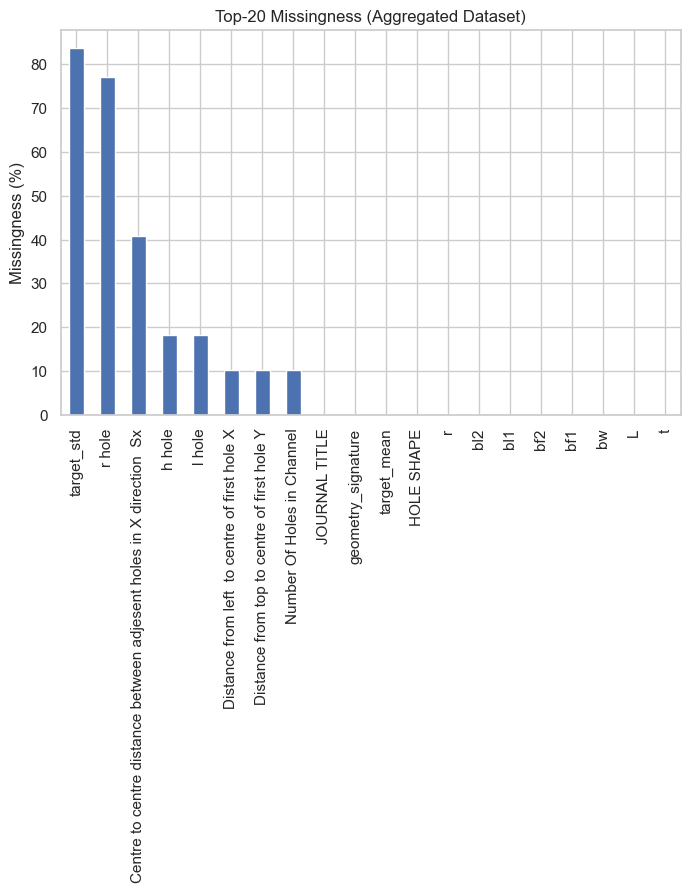

In [126]:
# Missingness % bar chart
missing_pct = df_agg.isna().mean().sort_values(ascending=False) * 100

plt.figure(figsize=(8, 5))
missing_pct.head(20).plot(kind="bar")
plt.ylabel("Missingness (%)")
plt.title("Top-20 Missingness (Aggregated Dataset)")
plt.tight_layout()
savefig("missingness_top20")
plt.show()


Saved: outputs/figures/missingness_by_hole_shape.png


/var/folders/2r/65b3v1496498f35zwrwmt7900000gn/T/ipykernel_72573/2316547688.py:21: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


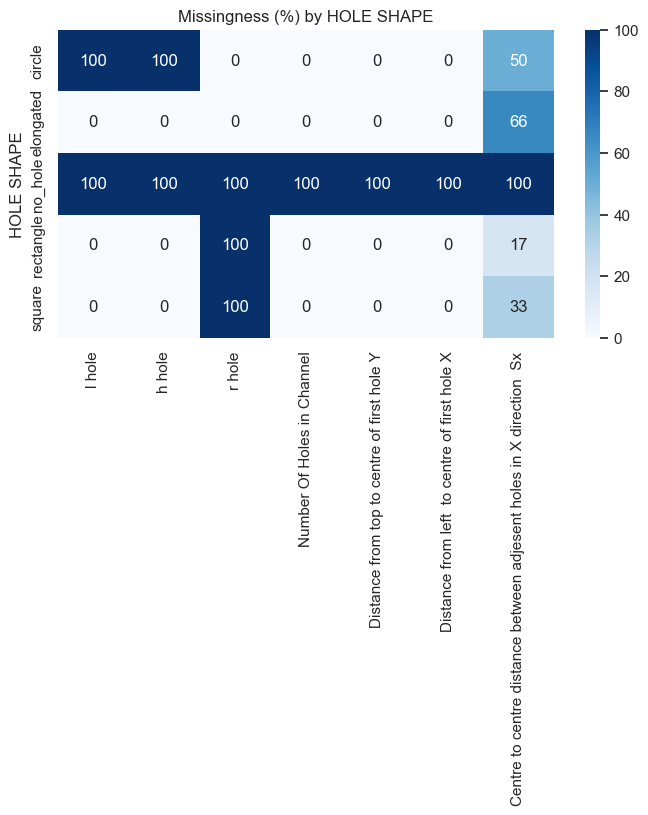

In [127]:
# Conditional missingness by HOLE SHAPE (aggregated)
hole_cols = [
    "l hole", "h hole", "r hole",
    "Number Of Holes in Channel",
    "Distance from top to centre of first hole Y",
    "Distance from left  to centre of first hole X",
    "Centre to centre distance between adjesent holes in X direction  Sx",
]
shape_col = "HOLE SHAPE"

missing_by_shape = (
    df_agg.groupby(shape_col)[hole_cols]
          .apply(lambda g: g.isna().mean() * 100)
          .sort_index()
)

plt.figure(figsize=(8, 4))
sns.heatmap(missing_by_shape, annot=True, fmt=".0f", cmap="Blues")
plt.title("Missingness (%) by HOLE SHAPE")
plt.ylabel("HOLE SHAPE")
plt.tight_layout()
savefig("missingness_by_hole_shape")
plt.show()


Saved: outputs/figures/sx_missing_by_holes.png


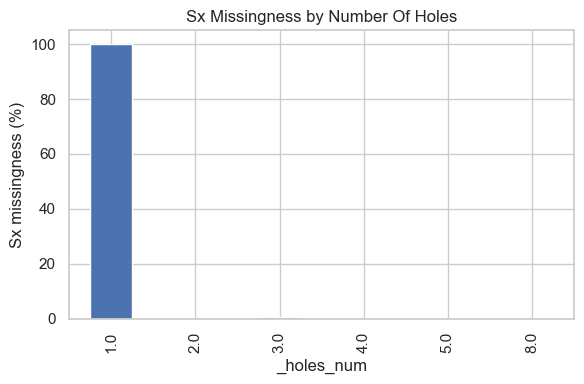

In [128]:
# Sx missingness by Number Of Holes
holes_col = "Number Of Holes in Channel"
sx_col = "Centre to centre distance between adjesent holes in X direction  Sx"

holes_num = pd.to_numeric(df_agg[holes_col], errors="coerce")
sx_missing_by_holes = (
    df_agg.assign(_holes_num=holes_num)
          .groupby("_holes_num")[sx_col]
          .apply(lambda s: s.isna().mean() * 100)
)

plt.figure(figsize=(6, 4))
sx_missing_by_holes.plot(kind="bar")
plt.ylabel("Sx missingness (%)")
plt.title("Sx Missingness by Number Of Holes")
plt.tight_layout()
savefig("sx_missing_by_holes")
plt.show()


Saved: outputs/figures/target_hist.png


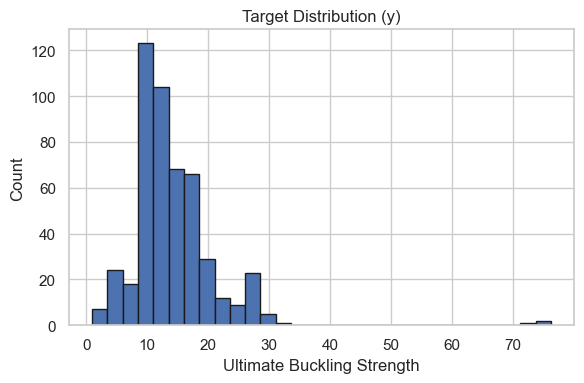

Saved: outputs/figures/target_box.png


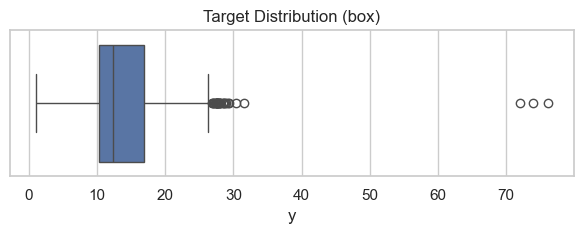

Saved: outputs/figures/target_by_y_from_fem.png


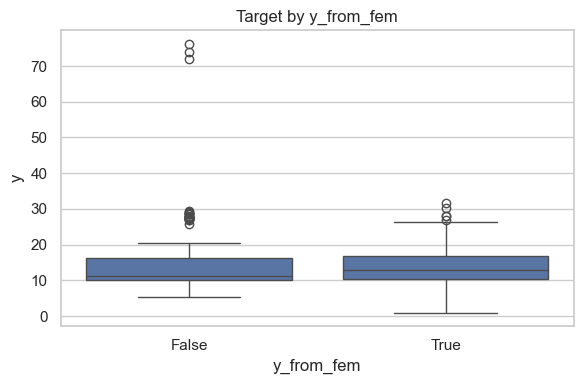

In [129]:
# Target distribution (hist + box) and split by y_from_fem (row-level)
plt.figure(figsize=(6, 4))
plt.hist(df["y"], bins=30, edgecolor="k")
plt.title("Target Distribution (y)")
plt.xlabel("Ultimate Buckling Strength")
plt.ylabel("Count")
plt.tight_layout()
savefig("target_hist")
plt.show()

plt.figure(figsize=(6, 2.5))
sns.boxplot(x=df["y"])
plt.title("Target Distribution (box)")
plt.tight_layout()
savefig("target_box")
plt.show()

plt.figure(figsize=(6, 4))
sns.boxplot(data=df, x="y_from_fem", y="y")
plt.title("Target by y_from_fem")
plt.tight_layout()
savefig("target_by_y_from_fem")
plt.show()


Saved: outputs/figures/target_by_hole_shape.png


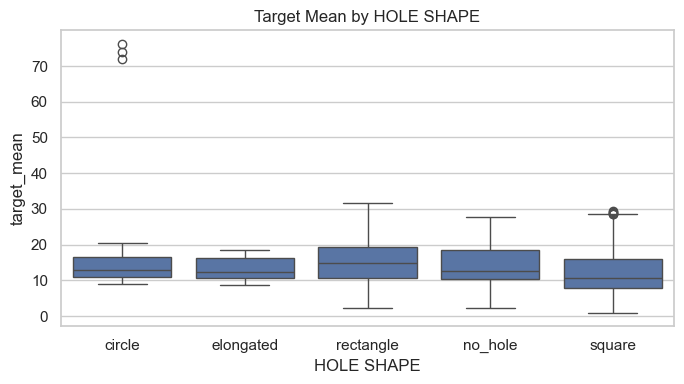

In [130]:
# Target vs HOLE SHAPE (aggregated)
plt.figure(figsize=(7, 4))
sns.boxplot(data=df_agg, x=shape_col, y="target_mean")
plt.title("Target Mean by HOLE SHAPE")
plt.tight_layout()
savefig("target_by_hole_shape")
plt.show()


Saved: outputs/figures/scatter_target_vs_target_std.png


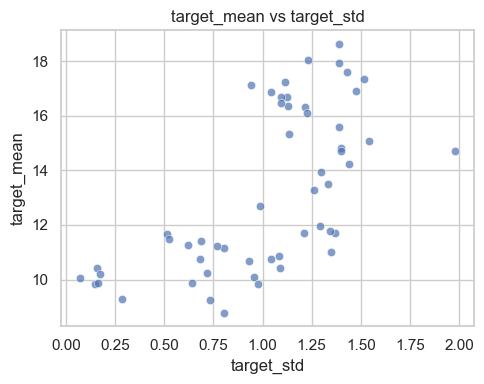

Saved: outputs/figures/scatter_target_vs_replicate_count.png


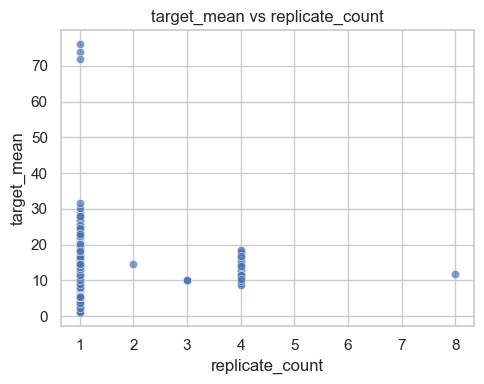

In [131]:
# Scatter: top numeric features vs target (aggregated)
num_cols = [c for c in df_agg.columns if c not in [shape_col] and pd.api.types.is_numeric_dtype(df_agg[c])]
# Pick top 6 numeric features by absolute correlation with target_mean
corr = df_agg[num_cols].corr()["target_mean"].abs().sort_values(ascending=False)
top_feats = [c for c in corr.index if c != "target_mean"][:6]

for c in top_feats:
    plt.figure(figsize=(5, 4))
    sns.scatterplot(data=df_agg, x=c, y="target_mean", alpha=0.7)
    plt.title(f"target_mean vs {c}")
    plt.tight_layout()
    savefig(f"scatter_target_vs_{c}")
    plt.show()


Saved: outputs/figures/rows_per_journal.png


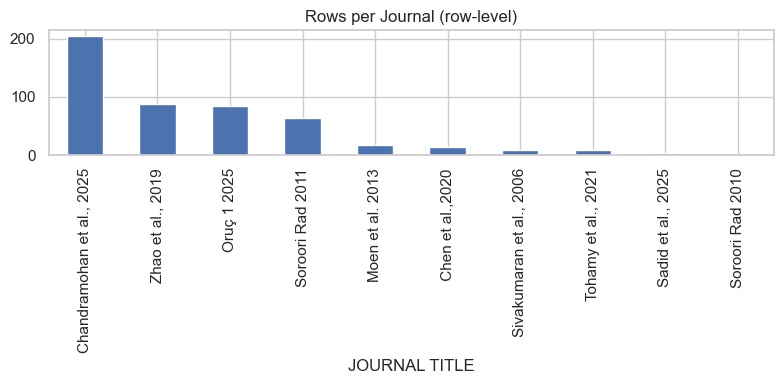

Saved: outputs/figures/target_by_journal.png


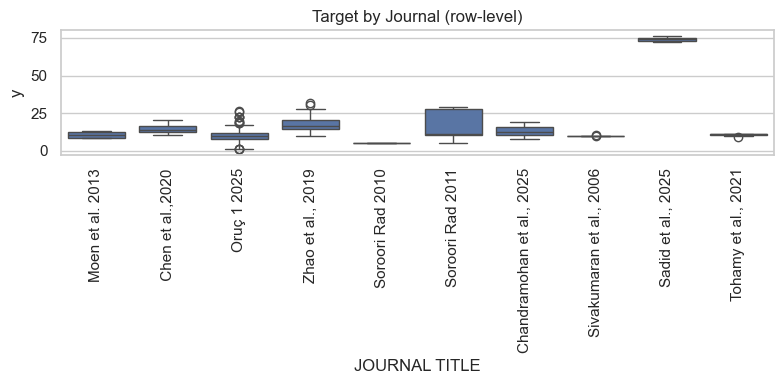

Saved: outputs/figures/hole_shape_mix_by_journal.png


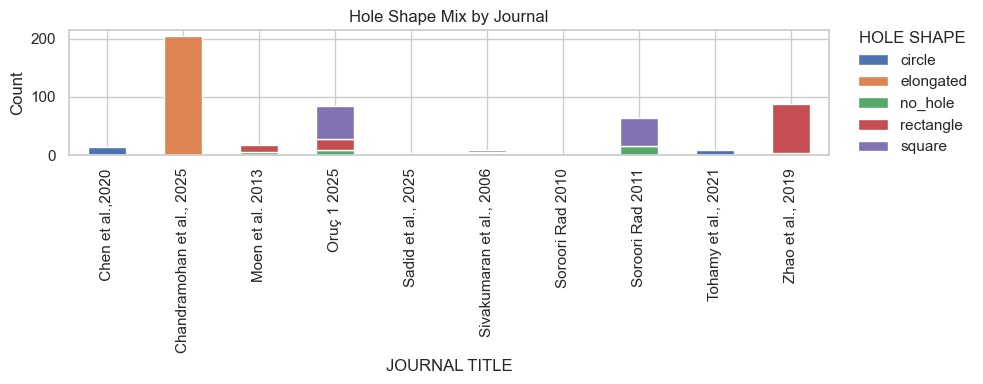

In [132]:
# Metadata diagnostics (row-level)
plt.figure(figsize=(8, 4))
df["JOURNAL TITLE"].value_counts().plot(kind="bar")
plt.title("Rows per Journal (row-level)")
plt.tight_layout()
savefig("rows_per_journal")
plt.show()

plt.figure(figsize=(8, 4))
sns.boxplot(data=df, x="JOURNAL TITLE", y="y")
plt.title("Target by Journal (row-level)")
plt.xticks(rotation=90)
plt.tight_layout()
savefig("target_by_journal")
plt.show()

# Fix legend placement: hole shape mix by journal
ct = pd.crosstab(df["JOURNAL TITLE"], df["HOLE SHAPE"])

ax = ct.plot(kind="bar", stacked=True, figsize=(10, 4))
ax.set_title("Hole Shape Mix by Journal")
ax.set_xlabel("JOURNAL TITLE")
ax.set_ylabel("Count")
ax.tick_params(axis="x", rotation=90)

# move legend outside
ax.legend(
    title="HOLE SHAPE",
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    frameon=False
)

plt.tight_layout()
savefig("hole_shape_mix_by_journal")
plt.show()




In [133]:
# Phase 5J — Outlier diagnostics (no removal)
id_cols = [c for c in ["SL. No", "JOURNAL TITLE", "SPECIMEN"] if c in df.columns]

# Overall outliers by IQR on row-level y
q1, q3 = df["y"].quantile([0.25, 0.75])
iqr = q3 - q1
upper = q3 + 1.5 * iqr

outliers = df[df["y"] > upper].copy()
print("Outlier threshold (IQR):", upper)
print("Outlier rows:", len(outliers))
print(outliers[id_cols + ["y", "HOLE SHAPE", "t", "L", "bw", "bf1", "bf2"]].sort_values("y", ascending=False))

# Journal-level summary
by_journal = df.groupby("JOURNAL TITLE")["y"].agg(["count", "mean", "std", "min", "max"]).sort_values("max", ascending=False)
print("\nTop journals by max(y):")
print(by_journal.head(10))

# Flag for later analysis (keep data)
df["outlier_y_iqr"] = df["y"] > upper
print("\nOutlier count by journal:")
print(df.loc[df["outlier_y_iqr"]].groupby("JOURNAL TITLE")["y"].size())


Outlier threshold (IQR): 26.6475
Outlier rows: 31
    SL. No       JOURNAL TITLE               SPECIMEN       y HOLE SHAPE  \
483    485  Sadid et al., 2025               D137-S68  76.200     circle   
484    486  Sadid et al., 2025               D148-S57  73.930     circle   
485    487  Sadid et al., 2025               D160-S45  72.074     circle   
202    203   Zhao et al., 2019        H220r0.2d40t3.0  31.570  rectangle   
203    204   Zhao et al., 2019        H220r0.4d40t3.0  30.370  rectangle   
268    269    Soroori Rad 2011   1200 S 162-68-85-3-1  29.350     square   
257    258    Soroori Rad 2011   1200 S 162-68-95-3-2  29.210     square   
255    256    Soroori Rad 2011   1200 S 162-68-95-2-2  28.960     square   
256    257    Soroori Rad 2011   1200 S 162-68-95-3-1  28.730     square   
269    270    Soroori Rad 2011   1200 S 162-68-85-3-2  28.560     square   
266    267    Soroori Rad 2011   1200 S 162-68-85-2-1  28.470     square   
265    266    Soroori Rad 2011   1200 

Saved: outputs/figures/hole_shape_mix_by_journal.png


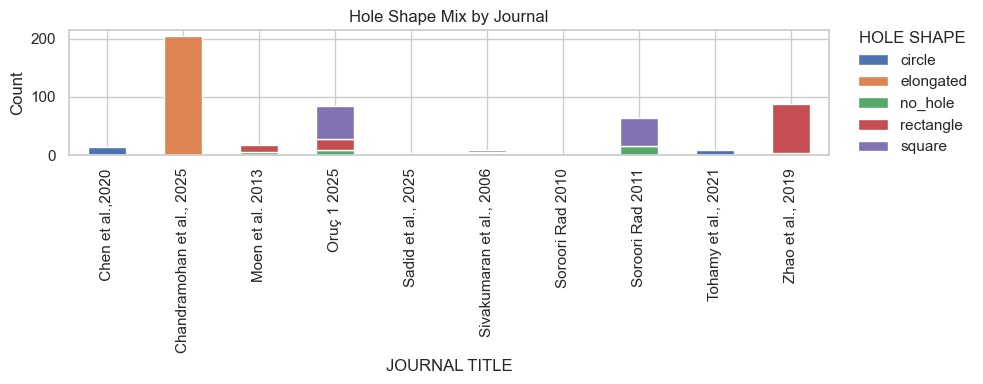

In [134]:
# Fix legend placement: hole shape mix by journal
ct = pd.crosstab(df["JOURNAL TITLE"], df["HOLE SHAPE"])

ax = ct.plot(kind="bar", stacked=True, figsize=(10, 4))
ax.set_title("Hole Shape Mix by Journal")
ax.set_xlabel("JOURNAL TITLE")
ax.set_ylabel("Count")
ax.tick_params(axis="x", rotation=90)

# move legend outside
ax.legend(
    title="HOLE SHAPE",
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    frameon=False
)

plt.tight_layout()
savefig("hole_shape_mix_by_journal")
plt.show()


In [135]:
# Hole shape mix by journal as a table
hole_shape_table = pd.crosstab(df["JOURNAL TITLE"], df["HOLE SHAPE"])
display(hole_shape_table)

# Optional: add totals and save
hole_shape_table["total"] = hole_shape_table.sum(axis=1)
hole_shape_table = hole_shape_table.sort_values("total", ascending=False)

Path("outputs/tables").mkdir(parents=True, exist_ok=True)
hole_shape_table.to_csv("outputs/tables/hole_shape_by_journal.csv")
print("Saved: outputs/tables/hole_shape_by_journal.csv")


HOLE SHAPE,circle,elongated,no_hole,rectangle,square
JOURNAL TITLE,,,,,
"Chen et al.,2020",14,0,0,0,0
"Chandramohan et al., 2025",0,204,0,0,0
Moen et al. 2013,0,0,6,12,0
Oruç 1 2025,0,0,8,19,57
"Sadid et al., 2025",3,0,0,0,0
"Sivakumaran et al., 2006",3,0,0,3,3
Soroori Rad 2010,0,0,1,0,0
Soroori Rad 2011,0,0,15,0,48
"Tohamy et al., 2021",8,0,0,0,0


Saved: outputs/tables/hole_shape_by_journal.csv


In [136]:
# Pre‑Phase 6 — Do geometry_signature values repeat across journals?
journals_per_geom = df_agg.groupby("geometry_signature")["JOURNAL TITLE"].nunique().sort_values(ascending=False)
repeat_geoms = journals_per_geom[journals_per_geom > 1]

print("unique geometry_signature:", df_agg["geometry_signature"].nunique())
print("geometry_signature in >1 journal:", int(repeat_geoms.shape[0]))
print("max journals per geometry_signature:", int(journals_per_geom.max()))
print("top repeats:")
print(repeat_geoms.head(10))

rows_in_repeated = df_agg[df_agg["geometry_signature"].isin(repeat_geoms.index)]
print("rows in repeated geometries (df_agg):", len(rows_in_repeated))


unique geometry_signature: 331
geometry_signature in >1 journal: 0
max journals per geometry_signature: 1
top repeats:
Series([], Name: JOURNAL TITLE, dtype: int64)
rows in repeated geometries (df_agg): 0


In [137]:
# Phase 6A — Grouped holdout split (20% by geometry_signature)
from sklearn.model_selection import GroupShuffleSplit, GroupKFold

RANDOM_SEED = globals().get("RANDOM_SEED", 42)

if "feature_cols" not in globals():
    exclude = {"JOURNAL TITLE", "geometry_signature", "target_mean", "target_std", "replicate_count"}
    feature_cols = [c for c in df_agg.columns if c not in exclude]

df_model = df_agg.copy()
X_model = df_model[feature_cols].copy()
y_model = df_model["target_mean"].copy()
groups = df_model["geometry_signature"].copy()

print("df_model rows:", len(df_model))
print("unique groups:", groups.nunique())

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=RANDOM_SEED)
train_idx, test_idx = next(gss.split(X_model, y_model, groups=groups))

df_train = df_model.iloc[train_idx].copy()
df_test = df_model.iloc[test_idx].copy()

print("train rows:", len(df_train), "test rows:", len(df_test))
print("train groups:", df_train["geometry_signature"].nunique(),
      "test groups:", df_test["geometry_signature"].nunique())

group_overlap = set(df_train["geometry_signature"]).intersection(set(df_test["geometry_signature"]))
print("group overlap (should be 0):", len(group_overlap))


df_model rows: 331
unique groups: 331
train rows: 264 test rows: 67
train groups: 264 test groups: 67
group overlap (should be 0): 0


In [138]:
# Phase 6B — GroupKFold (5 folds) on training set
X_train = X_model.iloc[train_idx]
y_train = y_model.iloc[train_idx]
groups_train = groups.iloc[train_idx]

gkf = GroupKFold(n_splits=5)
cv_splits = list(gkf.split(X_train, y_train, groups=groups_train))

print("cv folds:", len(cv_splits))
for i, (tr_idx, val_idx) in enumerate(cv_splits, start=1):
    tr_groups = set(groups_train.iloc[tr_idx])
    val_groups = set(groups_train.iloc[val_idx])
    overlap = tr_groups.intersection(val_groups)
    print(f"Fold {i}: train_rows={len(tr_idx)} val_rows={len(val_idx)} overlap_groups={len(overlap)}")


cv folds: 5
Fold 1: train_rows=211 val_rows=53 overlap_groups=0
Fold 2: train_rows=211 val_rows=53 overlap_groups=0
Fold 3: train_rows=211 val_rows=53 overlap_groups=0
Fold 4: train_rows=211 val_rows=53 overlap_groups=0
Fold 5: train_rows=212 val_rows=52 overlap_groups=0


In [139]:
# Phase 7A — Preprocessing pipelines (linear + tree)
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Ensure feature_cols exist
if "feature_cols" not in globals():
    exclude = {"JOURNAL TITLE", "geometry_signature", "target_mean", "target_std", "replicate_count"}
    feature_cols = [c for c in df_agg.columns if c not in exclude]

# Ensure numeric/categorical cols exist
def is_numeric_col(s, threshold=0.9):
    if pd.api.types.is_numeric_dtype(s):
        return True
    s_non_null = s.dropna()
    if s_non_null.empty:
        return False
    converted = pd.to_numeric(s_non_null, errors="coerce")
    return converted.notna().mean() >= threshold

X_tmp = df_agg[feature_cols].copy()
numeric_cols = [c for c in feature_cols if is_numeric_col(X_tmp[c])]
categorical_cols = [c for c in feature_cols if c not in numeric_cols]

# Treat Number Of Holes as categorical for linear models
holes_col = "Number Of Holes in Channel"
linear_categorical_cols = list(set(categorical_cols + ([holes_col] if holes_col in feature_cols else [])))
linear_numeric_cols = [c for c in numeric_cols if c not in linear_categorical_cols]

# OneHotEncoder compatibility (sklearn version)
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

# Linear pipeline preprocessor
preprocess_linear = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), linear_numeric_cols),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("ohe", ohe)
        ]), linear_categorical_cols),
    ],
    remainder="drop"
)

# Tree pipeline preprocessor (no scaling)
preprocess_tree = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median"))
        ]), numeric_cols),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("ohe", ohe)
        ]), categorical_cols),
    ],
    remainder="drop"
)

print("Linear numeric cols:", len(linear_numeric_cols))
print("Linear categorical cols:", len(linear_categorical_cols))
print("Tree numeric cols:", len(numeric_cols))
print("Tree categorical cols:", len(categorical_cols))


Linear numeric cols: 17
Linear categorical cols: 2
Tree numeric cols: 18
Tree categorical cols: 1


In [140]:
# Phase 7B — Smoke test (single fold)
def pearson_corr(y_true, y_pred):
    if len(y_true) < 2:
        return np.nan
    return np.corrcoef(y_true, y_pred)[0, 1]

# Ensure we have train split and CV splits from Phase 6
if "cv_splits" not in globals():
    raise ValueError("cv_splits not found. Run Phase 6 first.")

fold_idx = 0
tr_idx, val_idx = cv_splits[fold_idx]

X_train_fold = X_train.iloc[tr_idx]
y_train_fold = y_train.iloc[tr_idx]
X_val_fold = X_train.iloc[val_idx]
y_val_fold = y_train.iloc[val_idx]

# Linear smoke test
linear_model = Ridge(alpha=1.0, random_state=RANDOM_SEED)
pipe_linear = Pipeline([
    ("prep", preprocess_linear),
    ("model", linear_model),
])

pipe_linear.fit(X_train_fold, y_train_fold)
pred_linear = pipe_linear.predict(X_val_fold)
mae_linear = mean_absolute_error(y_val_fold, pred_linear)
corr_linear = pearson_corr(y_val_fold, pred_linear)

print(f"[Linear smoke] MAE={mae_linear:.3f} | Pearson={corr_linear:.3f} | n_val={len(y_val_fold)}")

# Tree smoke test
tree_model = RandomForestRegressor(
    n_estimators=200,
    random_state=RANDOM_SEED,
    n_jobs=-1
)
pipe_tree = Pipeline([
    ("prep", preprocess_tree),
    ("model", tree_model),
])

pipe_tree.fit(X_train_fold, y_train_fold)
pred_tree = pipe_tree.predict(X_val_fold)
mae_tree = mean_absolute_error(y_val_fold, pred_tree)
corr_tree = pearson_corr(y_val_fold, pred_tree)

print(f"[Tree smoke] MAE={mae_tree:.3f} | Pearson={corr_tree:.3f} | n_val={len(y_val_fold)}")


[Linear smoke] MAE=1.090 | Pearson=0.991 | n_val=53
[Tree smoke] MAE=1.130 | Pearson=0.989 | n_val=53


In [141]:
# Phase 8A — Grid search with OOF + holdout metrics (small grids)

from sklearn.base import clone
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.model_selection import GroupKFold
from itertools import product

RANDOM_SEED = globals().get("RANDOM_SEED", 42)

# Ensure Phase 6 artifacts exist
if "df_train" not in globals() or "df_test" not in globals():
    raise ValueError("df_train/df_test not found. Run Phase 6 first.")

if "feature_cols" not in globals():
    exclude = {"JOURNAL TITLE", "geometry_signature", "target_mean", "target_std", "replicate_count"}
    feature_cols = [c for c in df_agg.columns if c not in exclude]

X_train = df_train[feature_cols].copy()
y_train = df_train["target_mean"].copy()
groups_train = df_train["geometry_signature"].copy()

X_test = df_test[feature_cols].copy()
y_test = df_test["target_mean"].copy()

# Ensure preprocessors exist (rebuild if missing)
if "preprocess_linear" not in globals() or "preprocess_tree" not in globals():
    from sklearn.compose import ColumnTransformer
    from sklearn.preprocessing import OneHotEncoder, StandardScaler
    from sklearn.impute import SimpleImputer
    from sklearn.pipeline import Pipeline

    def is_numeric_col(s, threshold=0.9):
        if pd.api.types.is_numeric_dtype(s):
            return True
        s_non_null = s.dropna()
        if s_non_null.empty:
            return False
        converted = pd.to_numeric(s_non_null, errors="coerce")
        return converted.notna().mean() >= threshold

    X_tmp = df_agg[feature_cols].copy()
    numeric_cols = [c for c in feature_cols if is_numeric_col(X_tmp[c])]
    categorical_cols = [c for c in feature_cols if c not in numeric_cols]

    holes_col = "Number Of Holes in Channel"
    linear_categorical_cols = list(set(categorical_cols + ([holes_col] if holes_col in feature_cols else [])))
    linear_numeric_cols = [c for c in numeric_cols if c not in linear_categorical_cols]

    try:
        ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    except TypeError:
        ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

    preprocess_linear = ColumnTransformer(
        transformers=[
            ("num", Pipeline([("imputer", SimpleImputer(strategy="median")),
                              ("scaler", StandardScaler())]), linear_numeric_cols),
            ("cat", Pipeline([("imputer", SimpleImputer(strategy="most_frequent")),
                              ("ohe", ohe)]), linear_categorical_cols),
        ],
        remainder="drop"
    )

    preprocess_tree = ColumnTransformer(
        transformers=[
            ("num", Pipeline([("imputer", SimpleImputer(strategy="median"))]), numeric_cols),
            ("cat", Pipeline([("imputer", SimpleImputer(strategy="most_frequent")),
                              ("ohe", ohe)]), categorical_cols),
        ],
        remainder="drop"
    )

def pearson_corr(y_true, y_pred):
    if len(y_true) < 2:
        return np.nan
    return np.corrcoef(y_true, y_pred)[0, 1]

def param_grid(grid_dict):
    keys = list(grid_dict.keys())
    for values in product(*grid_dict.values()):
        yield dict(zip(keys, values))

def oof_predict(pipeline, X, y, groups, splits):
    oof = np.full(len(y), np.nan, dtype=float)
    for tr_idx, val_idx in splits:
        model = clone(pipeline)
        model.fit(X.iloc[tr_idx], y.iloc[tr_idx])
        oof[val_idx] = model.predict(X.iloc[val_idx])
    return oof

# Use consistent CV splits
gkf = GroupKFold(n_splits=5)
cv_splits = list(gkf.split(X_train, y_train, groups=groups_train))

model_specs = [
    {
        "name": "Ridge",
        "family": "linear",
        "estimator": Ridge(),
        "params": {"model__alpha": [0.1, 1.0, 10.0]},
        "preprocess": preprocess_linear,
    },
    {
        "name": "Lasso",
        "family": "linear",
        "estimator": Lasso(max_iter=10000),
        "params": {"model__alpha": [0.001, 0.01, 0.1]},
        "preprocess": preprocess_linear,
    },
    {
        "name": "ElasticNet",
        "family": "linear",
        "estimator": ElasticNet(max_iter=10000),
        "params": {"model__alpha": [0.01, 0.1], "model__l1_ratio": [0.2, 0.5, 0.8]},
        "preprocess": preprocess_linear,
    },
    {
        "name": "RandomForest",
        "family": "tree",
        "estimator": RandomForestRegressor(
            n_estimators=300,
            random_state=RANDOM_SEED,
            n_jobs=-1
        ),
        "params": {"model__max_depth": [None, 10], "model__min_samples_leaf": [1, 3]},
        "preprocess": preprocess_tree,
    },
    {
        "name": "HistGradientBoosting",
        "family": "tree",
        "estimator": HistGradientBoostingRegressor(
            random_state=RANDOM_SEED,
            max_iter=300
        ),
        "params": {"model__learning_rate": [0.05, 0.1], "model__max_depth": [3, None], "model__l2_regularization": [0.0, 0.1]},
        "preprocess": preprocess_tree,
    },
]

print("Train rows:", len(X_train), "Holdout rows:", len(X_test))
print("CV folds:", len(cv_splits))


Train rows: 264 Holdout rows: 67
CV folds: 5


In [142]:
# Phase 8B — Run grids and compute metrics
results = []
pred_store = {}

for spec in model_specs:
    base_pipe = Pipeline([
        ("prep", spec["preprocess"]),
        ("model", spec["estimator"]),
    ])
    for params in param_grid(spec["params"]):
        pipe = clone(base_pipe).set_params(**params)

        oof_pred = oof_predict(pipe, X_train, y_train, groups_train, cv_splits)
        oof_mae = mean_absolute_error(y_train, oof_pred)
        oof_corr = pearson_corr(y_train, oof_pred)

        pipe_fit = clone(base_pipe).set_params(**params)
        pipe_fit.fit(X_train, y_train)
        holdout_pred = pipe_fit.predict(X_test)

        holdout_mae = mean_absolute_error(y_test, holdout_pred)
        holdout_corr = pearson_corr(y_test, holdout_pred)

        model_id = f"{spec['name']}|{params}"
        results.append({
            "model_id": model_id,
            "family": spec["family"],
            "oof_mae": oof_mae,
            "oof_pearson": oof_corr,
            "holdout_mae": holdout_mae,
            "holdout_pearson": holdout_corr,
            "n_train": len(X_train),
            "n_test": len(X_test),
        })
        pred_store[model_id] = {
            "oof_pred": oof_pred,
            "holdout_pred": holdout_pred,
        }

results_df = pd.DataFrame(results).sort_values(["family", "holdout_mae"])
display(results_df.head(10))

Path("outputs/tables").mkdir(parents=True, exist_ok=True)
results_df.to_csv("outputs/tables/metrics_phase8.csv", index=False)
print("Saved: outputs/tables/metrics_phase8.csv")


,model_id,family,oof_mae,oof_pearson,holdout_mae,holdout_pearson,n_train,n_test
3,Lasso|{'model__alpha': 0.001},linear,0.991297,0.989503,0.957080,0.968094,264,67
0,Ridge|{'model__alpha': 0.1},linear,0.993796,0.989486,0.959214,0.967907,264,67
4,Lasso|{'model__alpha': 0.01},linear,0.998526,0.989264,0.979845,0.967666,264,67
8,"ElasticNet|{'model__alpha': 0.01, 'model__l1_r...",linear,1.010971,0.989112,1.014663,0.966489,264,67
1,Ridge|{'model__alpha': 1.0},linear,1.004682,0.989247,1.016840,0.965915,264,67
7,"ElasticNet|{'model__alpha': 0.01, 'model__l1_r...",linear,1.020750,0.989009,1.046659,0.965298,264,67
6,"ElasticNet|{'model__alpha': 0.01, 'model__l1_r...",linear,1.031292,0.988875,1.073393,0.963991,264,67
5,Lasso|{'model__alpha': 0.1},linear,1.315404,0.982819,1.227769,0.960030,264,67
2,Ridge|{'model__alpha': 10.0},linear,1.317111,0.983802,1.308312,0.952092,264,67
11,"ElasticNet|{'model__alpha': 0.1, 'model__l1_ra...",linear,1.381096,0.981753,1.319913,0.954286,264,67


Saved: outputs/tables/metrics_phase8.csv


In [143]:
results_df

,model_id,family,oof_mae,oof_pearson,holdout_mae,holdout_pearson,n_train,n_test
3,Lasso|{'model__alpha': 0.001},linear,0.991297,0.989503,0.957080,0.968094,264,67
0,Ridge|{'model__alpha': 0.1},linear,0.993796,0.989486,0.959214,0.967907,264,67
4,Lasso|{'model__alpha': 0.01},linear,0.998526,0.989264,0.979845,0.967666,264,67
8,"ElasticNet|{'model__alpha': 0.01, 'model__l1_r...",linear,1.010971,0.989112,1.014663,0.966489,264,67
1,Ridge|{'model__alpha': 1.0},linear,1.004682,0.989247,1.016840,0.965915,264,67
7,"ElasticNet|{'model__alpha': 0.01, 'model__l1_r...",linear,1.020750,0.989009,1.046659,0.965298,264,67
6,"ElasticNet|{'model__alpha': 0.01, 'model__l1_r...",linear,1.031292,0.988875,1.073393,0.963991,264,67
5,Lasso|{'model__alpha': 0.1},linear,1.315404,0.982819,1.227769,0.960030,264,67
2,Ridge|{'model__alpha': 10.0},linear,1.317111,0.983802,1.308312,0.952092,264,67
11,"ElasticNet|{'model__alpha': 0.1, 'model__l1_ra...",linear,1.381096,0.981753,1.319913,0.954286,264,67


In [144]:
# Phase 9A — Select best models (overall + per family)
import ast

# Load results_df if not in memory
if "results_df" not in globals():
    results_df = pd.read_csv("outputs/tables/metrics_phase8.csv")

threshold = 0.90
eligible = results_df[results_df["holdout_pearson"] >= threshold].copy()

if eligible.empty:
    print("WARNING: No models meet Pearson >= 0.90; using all models.")
    eligible = results_df.copy()

best_overall = eligible.sort_values("holdout_mae").iloc[0]
best_linear = eligible[eligible["family"] == "linear"].sort_values("holdout_mae").iloc[0]
best_tree = eligible[eligible["family"] == "tree"].sort_values("holdout_mae").iloc[0]

selection_df = pd.DataFrame(
    [best_linear, best_tree, best_overall],
    index=["best_linear", "best_tree", "best_overall"],
)
display(selection_df[["model_id", "family", "holdout_mae", "holdout_pearson", "oof_mae", "oof_pearson"]])


,model_id,family,holdout_mae,holdout_pearson,oof_mae,oof_pearson
best_linear,Lasso|{'model__alpha': 0.001},linear,0.957080,0.968094,0.991297,0.989503
best_tree,"RandomForest|{'model__max_depth': None, 'model...",tree,0.885789,0.972605,0.949389,0.986686
best_overall,"RandomForest|{'model__max_depth': None, 'model...",tree,0.885789,0.972605,0.949389,0.986686


In [145]:
# Phase 9B — Build model lookup + get predictions
from sklearn.pipeline import Pipeline
from sklearn.base import clone
from sklearn.model_selection import GroupKFold
from itertools import product

def param_grid(grid_dict):
    keys = list(grid_dict.keys())
    for values in product(*grid_dict.values()):
        yield dict(zip(keys, values))

# Rebuild model_specs if missing
if "model_specs" not in globals():
    from sklearn.linear_model import Ridge, Lasso, ElasticNet
    from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor

    model_specs = [
        {
            "name": "Ridge",
            "family": "linear",
            "estimator": Ridge(),
            "params": {"model__alpha": [0.1, 1.0, 10.0]},
            "preprocess": preprocess_linear,
        },
        {
            "name": "Lasso",
            "family": "linear",
            "estimator": Lasso(max_iter=10000),
            "params": {"model__alpha": [0.001, 0.01, 0.1]},
            "preprocess": preprocess_linear,
        },
        {
            "name": "ElasticNet",
            "family": "linear",
            "estimator": ElasticNet(max_iter=10000),
            "params": {"model__alpha": [0.01, 0.1], "model__l1_ratio": [0.2, 0.5, 0.8]},
            "preprocess": preprocess_linear,
        },
        {
            "name": "RandomForest",
            "family": "tree",
            "estimator": RandomForestRegressor(n_estimators=300, random_state=RANDOM_SEED, n_jobs=-1),
            "params": {"model__max_depth": [None, 10], "model__min_samples_leaf": [1, 3]},
            "preprocess": preprocess_tree,
        },
        {
            "name": "HistGradientBoosting",
            "family": "tree",
            "estimator": HistGradientBoostingRegressor(random_state=RANDOM_SEED, max_iter=300),
            "params": {"model__learning_rate": [0.05, 0.1], "model__max_depth": [3, None], "model__l2_regularization": [0.0, 0.1]},
            "preprocess": preprocess_tree,
        },
    ]

# Build lookup from model_id -> (spec, params)
model_lookup = {}
for spec in model_specs:
    for params in param_grid(spec["params"]):
        model_id = f"{spec['name']}|{params}"
        model_lookup[model_id] = {"spec": spec, "params": params}

# Prepare train/test
X_train = df_train[feature_cols].copy()
y_train = df_train["target_mean"].copy()
groups_train = df_train["geometry_signature"].copy()

X_test = df_test[feature_cols].copy()
y_test = df_test["target_mean"].copy()

# CV splits for OOF if needed
gkf = GroupKFold(n_splits=5)
cv_splits = list(gkf.split(X_train, y_train, groups=groups_train))

def oof_predict(pipeline, X, y, splits):
    oof = np.full(len(y), np.nan, dtype=float)
    for tr_idx, val_idx in splits:
        model = clone(pipeline)
        model.fit(X.iloc[tr_idx], y.iloc[tr_idx])
        oof[val_idx] = model.predict(X.iloc[val_idx])
    return oof

best_overall_id = best_overall["model_id"]

# Use pred_store if available, else compute
if "pred_store" in globals() and best_overall_id in pred_store:
    oof_pred = pred_store[best_overall_id]["oof_pred"]
    holdout_pred = pred_store[best_overall_id]["holdout_pred"]
else:
    spec = model_lookup[best_overall_id]["spec"]
    params = model_lookup[best_overall_id]["params"]
    pipe = Pipeline([("prep", spec["preprocess"]), ("model", spec["estimator"])]).set_params(**params)

    oof_pred = oof_predict(pipe, X_train, y_train, cv_splits)

    pipe.fit(X_train, y_train)
    holdout_pred = pipe.predict(X_test)

print("Selected best_overall:", best_overall_id)


Selected best_overall: RandomForest|{'model__max_depth': None, 'model__min_samples_leaf': 1}


Saved: outputs/figures/oof_obs_vs_pred_best_overall.png


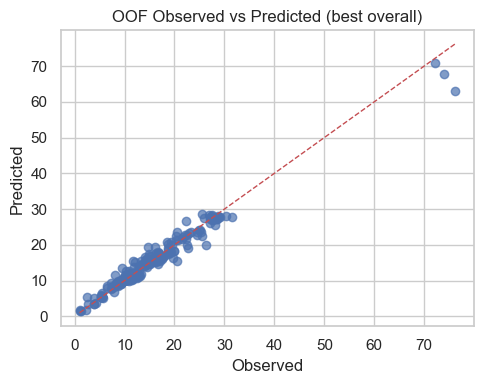

Saved: outputs/figures/holdout_obs_vs_pred_best_overall.png


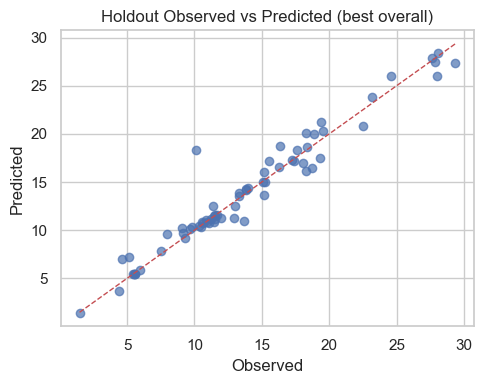

Saved: outputs/figures/holdout_residuals_vs_pred.png


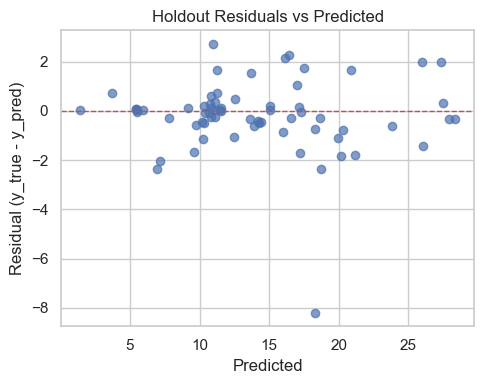

Saved: outputs/figures/holdout_residual_hist.png


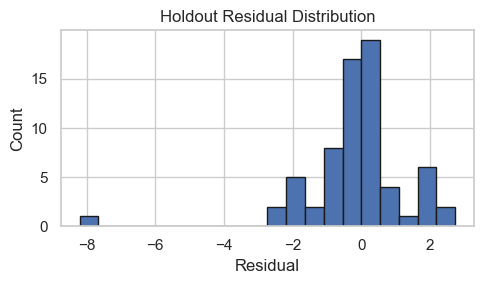

Saved: outputs/figures/holdout_mae_by_hole_shape.png


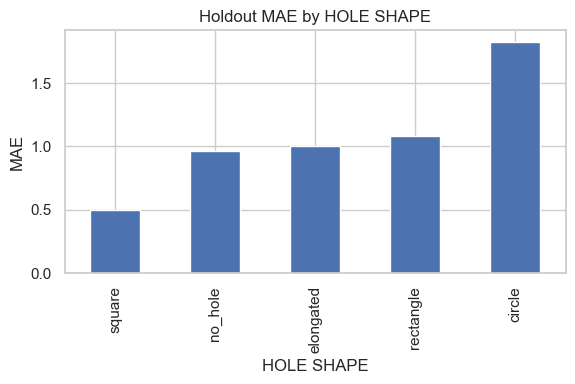

Saved: outputs/figures/holdout_mae_by_journal.png


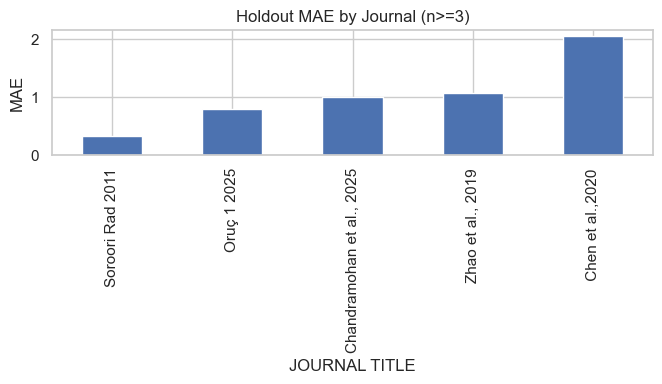

Saved tables: outputs/tables/mae_by_hole_shape_holdout.csv, outputs/tables/mae_by_journal_holdout.csv


In [146]:
# Phase 9C — Post-model plots (best overall)
from sklearn.metrics import mean_absolute_error

if "savefig" not in globals():
    from pathlib import Path
    FIG_DIR = Path("outputs/figures")
    FIG_DIR.mkdir(parents=True, exist_ok=True)
    def savefig(name):
        path = FIG_DIR / f"{name}.png"
        plt.savefig(path, dpi=150, bbox_inches="tight")
        print("Saved:", path)

# OOF: observed vs predicted
plt.figure(figsize=(5, 4))
plt.scatter(y_train, oof_pred, alpha=0.7)
mn, mx = y_train.min(), y_train.max()
plt.plot([mn, mx], [mn, mx], "r--", lw=1)
plt.xlabel("Observed")
plt.ylabel("Predicted")
plt.title("OOF Observed vs Predicted (best overall)")
plt.tight_layout()
savefig("oof_obs_vs_pred_best_overall")
plt.show()

# Holdout: observed vs predicted
plt.figure(figsize=(5, 4))
plt.scatter(y_test, holdout_pred, alpha=0.7)
mn, mx = y_test.min(), y_test.max()
plt.plot([mn, mx], [mn, mx], "r--", lw=1)
plt.xlabel("Observed")
plt.ylabel("Predicted")
plt.title("Holdout Observed vs Predicted (best overall)")
plt.tight_layout()
savefig("holdout_obs_vs_pred_best_overall")
plt.show()

# Residuals vs predicted (holdout)
residuals = y_test.values - holdout_pred
plt.figure(figsize=(5, 4))
plt.scatter(holdout_pred, residuals, alpha=0.7)
plt.axhline(0, color="r", linestyle="--", lw=1)
plt.xlabel("Predicted")
plt.ylabel("Residual (y_true - y_pred)")
plt.title("Holdout Residuals vs Predicted")
plt.tight_layout()
savefig("holdout_residuals_vs_pred")
plt.show()

# Residual distribution (holdout)
plt.figure(figsize=(5, 3))
plt.hist(residuals, bins=20, edgecolor="k")
plt.xlabel("Residual")
plt.ylabel("Count")
plt.title("Holdout Residual Distribution")
plt.tight_layout()
savefig("holdout_residual_hist")
plt.show()

# MAE by HOLE SHAPE (holdout)
holdout_df = df_test.copy()
holdout_df["y_true"] = y_test.values
holdout_df["y_pred"] = holdout_pred
holdout_df["abs_error"] = (holdout_df["y_true"] - holdout_df["y_pred"]).abs()

mae_by_shape = holdout_df.groupby("HOLE SHAPE")["abs_error"].mean().sort_values()
plt.figure(figsize=(6, 4))
mae_by_shape.plot(kind="bar")
plt.ylabel("MAE")
plt.title("Holdout MAE by HOLE SHAPE")
plt.tight_layout()
savefig("holdout_mae_by_hole_shape")
plt.show()

# MAE by JOURNAL TITLE (holdout)
journal_stats = (
    holdout_df.groupby("JOURNAL TITLE")["abs_error"]
              .agg(mae="mean", n="size")
              .sort_values("mae")
)
min_journal_n = 3
journal_stats = journal_stats[journal_stats["n"] >= min_journal_n]

plt.figure(figsize=(7, 4))
journal_stats["mae"].plot(kind="bar")
plt.title(f"Holdout MAE by Journal (n>={min_journal_n})")
plt.ylabel("MAE")
plt.xticks(rotation=90)
plt.tight_layout()
savefig("holdout_mae_by_journal")
plt.show()

# Save tables
Path("outputs/tables").mkdir(parents=True, exist_ok=True)
mae_by_shape.to_csv("outputs/tables/mae_by_hole_shape_holdout.csv")
journal_stats.to_csv("outputs/tables/mae_by_journal_holdout.csv")
print("Saved tables: outputs/tables/mae_by_hole_shape_holdout.csv, outputs/tables/mae_by_journal_holdout.csv")


Saved: outputs/figures/top_linear_coefficients.png


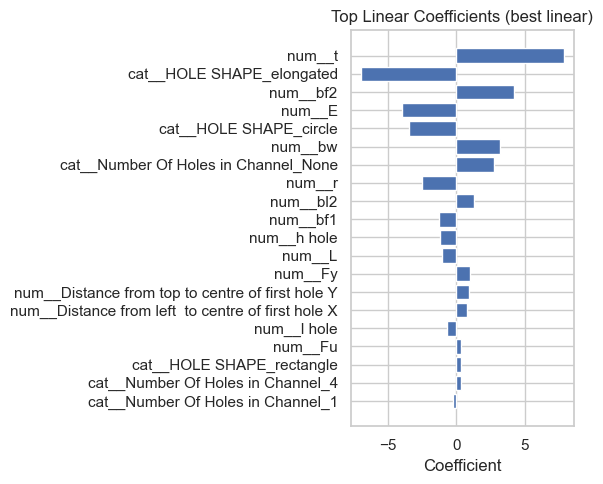

Saved: outputs/figures/top_tree_feature_importances.png


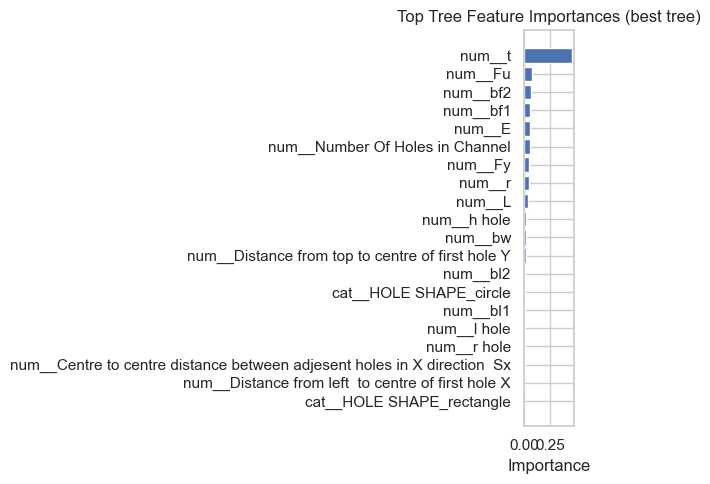

In [147]:
# Phase 9D — Interpretability (best linear + best tree)
def get_feature_names(preprocess):
    try:
        return preprocess.get_feature_names_out()
    except AttributeError:
        # fallback
        return [f"f{i}" for i in range(preprocess.transform(X_train[:1]).shape[1])]

def fit_pipeline(model_id):
    spec = model_lookup[model_id]["spec"]
    params = model_lookup[model_id]["params"]
    pipe = Pipeline([("prep", spec["preprocess"]), ("model", spec["estimator"])]).set_params(**params)
    pipe.fit(X_train, y_train)
    return pipe

# Linear coefficients
best_linear_id = best_linear["model_id"]
pipe_linear = fit_pipeline(best_linear_id)
linear_feature_names = get_feature_names(pipe_linear.named_steps["prep"])
coef = pipe_linear.named_steps["model"].coef_.ravel()

coef_df = pd.DataFrame({"feature": linear_feature_names, "coef": coef})
coef_df["abs_coef"] = coef_df["coef"].abs()
top_coef = coef_df.sort_values("abs_coef", ascending=False).head(20)

plt.figure(figsize=(6, 5))
plt.barh(top_coef["feature"][::-1], top_coef["coef"][::-1])
plt.title("Top Linear Coefficients (best linear)")
plt.xlabel("Coefficient")
plt.tight_layout()
savefig("top_linear_coefficients")
plt.show()

# Tree feature importances
best_tree_id = best_tree["model_id"]
pipe_tree = fit_pipeline(best_tree_id)
tree_model = pipe_tree.named_steps["model"]

if hasattr(tree_model, "feature_importances_"):
    tree_feature_names = get_feature_names(pipe_tree.named_steps["prep"])
    importances = tree_model.feature_importances_
    imp_df = pd.DataFrame({"feature": tree_feature_names, "importance": importances})
    top_imp = imp_df.sort_values("importance", ascending=False).head(20)

    plt.figure(figsize=(6, 5))
    plt.barh(top_imp["feature"][::-1], top_imp["importance"][::-1])
    plt.title("Top Tree Feature Importances (best tree)")
    plt.xlabel("Importance")
    plt.tight_layout()
    savefig("top_tree_feature_importances")
    plt.show()
else:
    print("Tree model does not expose feature_importances_. Consider permutation importance if needed.")


In [148]:
# Phase 10A — Final refit on full aggregated data + save artifacts
import ast
import joblib
from pathlib import Path
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error

# Safety checks
if "df_agg" not in globals():
    raise ValueError("df_agg not found. Run earlier phases first.")
if "df" not in globals():
    raise ValueError("df not found. Run earlier phases first.")
if "feature_cols" not in globals():
    exclude = {"JOURNAL TITLE", "geometry_signature", "target_mean", "target_std", "replicate_count"}
    feature_cols = [c for c in df_agg.columns if c not in exclude]

# Load results if needed
if "results_df" not in globals():
    results_df = pd.read_csv("outputs/tables/metrics_phase8.csv")

# Select best per family (Pearson >= 0.90)
eligible = results_df[results_df["holdout_pearson"] >= 0.90].copy()
if eligible.empty:
    print("WARNING: No models meet Pearson >= 0.90; using all models.")
    eligible = results_df.copy()

best_linear = eligible[eligible["family"] == "linear"].sort_values("holdout_mae").iloc[0]
best_tree = eligible[eligible["family"] == "tree"].sort_values("holdout_mae").iloc[0]

best_linear_id = best_linear["model_id"]
best_tree_id = best_tree["model_id"]

# Rebuild model specs (same as Phase 8)
model_specs = [
    {"name": "Ridge", "estimator": Ridge(), "preprocess": preprocess_linear},
    {"name": "Lasso", "estimator": Lasso(max_iter=10000), "preprocess": preprocess_linear},
    {"name": "ElasticNet", "estimator": ElasticNet(max_iter=10000), "preprocess": preprocess_linear},
    {"name": "RandomForest", "estimator": RandomForestRegressor(n_estimators=300, random_state=RANDOM_SEED, n_jobs=-1), "preprocess": preprocess_tree},
    {"name": "HistGradientBoosting", "estimator": HistGradientBoostingRegressor(random_state=RANDOM_SEED, max_iter=300), "preprocess": preprocess_tree},
]
spec_map = {s["name"]: s for s in model_specs}

def build_pipe(model_id):
    name, params_str = model_id.split("|", 1)
    params = ast.literal_eval(params_str)
    spec = spec_map[name]
    pipe = Pipeline([("prep", spec["preprocess"]), ("model", spec["estimator"])]).set_params(**params)
    return pipe

# Full data
X_full = df_agg[feature_cols].copy()
y_full = df_agg["target_mean"].copy()

# Fit final models
final_linear = build_pipe(best_linear_id)
final_tree = build_pipe(best_tree_id)

final_linear.fit(X_full, y_full)
final_tree.fit(X_full, y_full)

# Save models
models_dir = Path("outputs/models")
models_dir.mkdir(parents=True, exist_ok=True)
joblib.dump(final_linear, models_dir / "best_linear_model.joblib")
joblib.dump(final_tree, models_dir / "best_tree_model.joblib")

print("Saved models:")
print(" - outputs/models/best_linear_model.joblib")
print(" - outputs/models/best_tree_model.joblib")

# Save datasets
Path("data/interim").mkdir(parents=True, exist_ok=True)
df.to_csv("data/interim/cleaned.csv", index=False)
df_agg.to_csv("data/interim/aggregated.csv", index=False)
print("Saved datasets:")
print(" - data/interim/cleaned.csv")
print(" - data/interim/aggregated.csv")

# Save model selection summary
selection_df = pd.DataFrame([best_linear, best_tree], index=["best_linear", "best_tree"])
Path("outputs/tables").mkdir(parents=True, exist_ok=True)
selection_df.to_csv("outputs/tables/model_selection.csv", index=True)
print("Saved: outputs/tables/model_selection.csv")


Saved models:
 - outputs/models/best_linear_model.joblib
 - outputs/models/best_tree_model.joblib
Saved datasets:
 - data/interim/cleaned.csv
 - data/interim/aggregated.csv
Saved: outputs/tables/model_selection.csv


[Full fit] Linear MAE=0.888 | Pearson=0.989
[Full fit] Tree   MAE=0.311 | Pearson=0.998
Saved: outputs/figures/full_fit_obs_vs_pred_linear.png


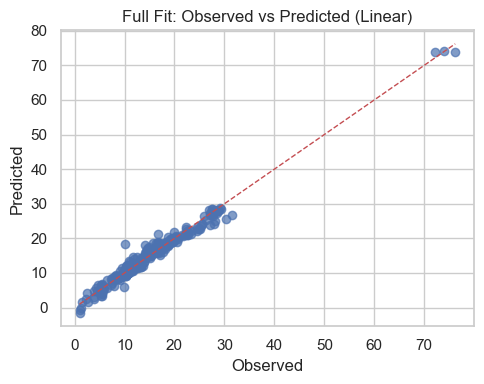

Saved: outputs/figures/full_fit_obs_vs_pred_tree.png


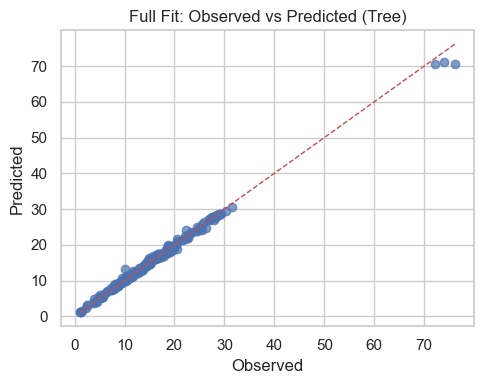

In [149]:
# Phase 10B — Final full-fit plots (in-sample diagnostics)
def pearson_corr(y_true, y_pred):
    if len(y_true) < 2:
        return np.nan
    return np.corrcoef(y_true, y_pred)[0, 1]

if "savefig" not in globals():
    FIG_DIR = Path("outputs/figures")
    FIG_DIR.mkdir(parents=True, exist_ok=True)
    def savefig(name):
        path = FIG_DIR / f"{name}.png"
        plt.savefig(path, dpi=150, bbox_inches="tight")
        print("Saved:", path)

# Predictions
pred_linear_full = final_linear.predict(X_full)
pred_tree_full = final_tree.predict(X_full)

# Metrics (in-sample)
mae_linear = mean_absolute_error(y_full, pred_linear_full)
corr_linear = pearson_corr(y_full, pred_linear_full)

mae_tree = mean_absolute_error(y_full, pred_tree_full)
corr_tree = pearson_corr(y_full, pred_tree_full)

print(f"[Full fit] Linear MAE={mae_linear:.3f} | Pearson={corr_linear:.3f}")
print(f"[Full fit] Tree   MAE={mae_tree:.3f} | Pearson={corr_tree:.3f}")

# Plot: observed vs predicted (linear)
plt.figure(figsize=(5, 4))
plt.scatter(y_full, pred_linear_full, alpha=0.7)
mn, mx = y_full.min(), y_full.max()
plt.plot([mn, mx], [mn, mx], "r--", lw=1)
plt.xlabel("Observed")
plt.ylabel("Predicted")
plt.title("Full Fit: Observed vs Predicted (Linear)")
plt.tight_layout()
savefig("full_fit_obs_vs_pred_linear")
plt.show()

# Plot: observed vs predicted (tree)
plt.figure(figsize=(5, 4))
plt.scatter(y_full, pred_tree_full, alpha=0.7)
plt.plot([mn, mx], [mn, mx], "r--", lw=1)
plt.xlabel("Observed")
plt.ylabel("Predicted")
plt.title("Full Fit: Observed vs Predicted (Tree)")
plt.tight_layout()
savefig("full_fit_obs_vs_pred_tree")
plt.show()
